<a href="https://colab.research.google.com/github/nasarar/Post_Covid19_Vacation_Projection/blob/Ryan/covid_19_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
4# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

In [ ]:
import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
import pandas as pd
import math

In [ ]:
df= pd.read_csv(
    'https://covid.ourworldindata.org/data/owid-covid-data.csv')
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


#Arima Model

In [ ]:
!pip install pmdarima

In [ ]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

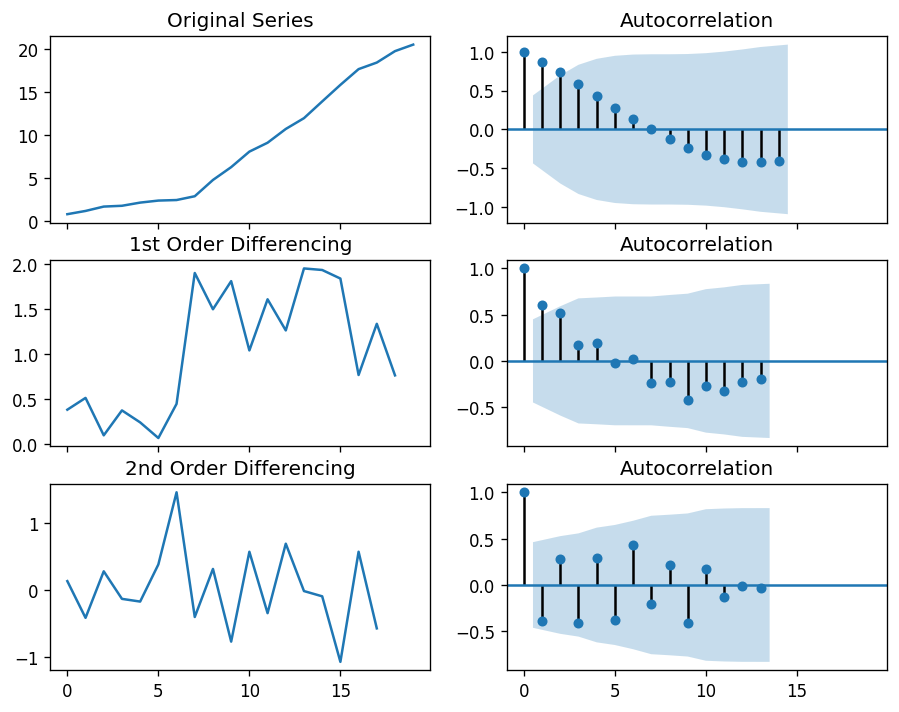

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=32.618, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=35.820, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=34.849, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=35.357, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=33.844, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=34.597, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=34.580, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=37.335, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=36.353, Time=0.04 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=30.661, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=33.510, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=32.947, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=32.635, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=32.617, Time=0.11 sec


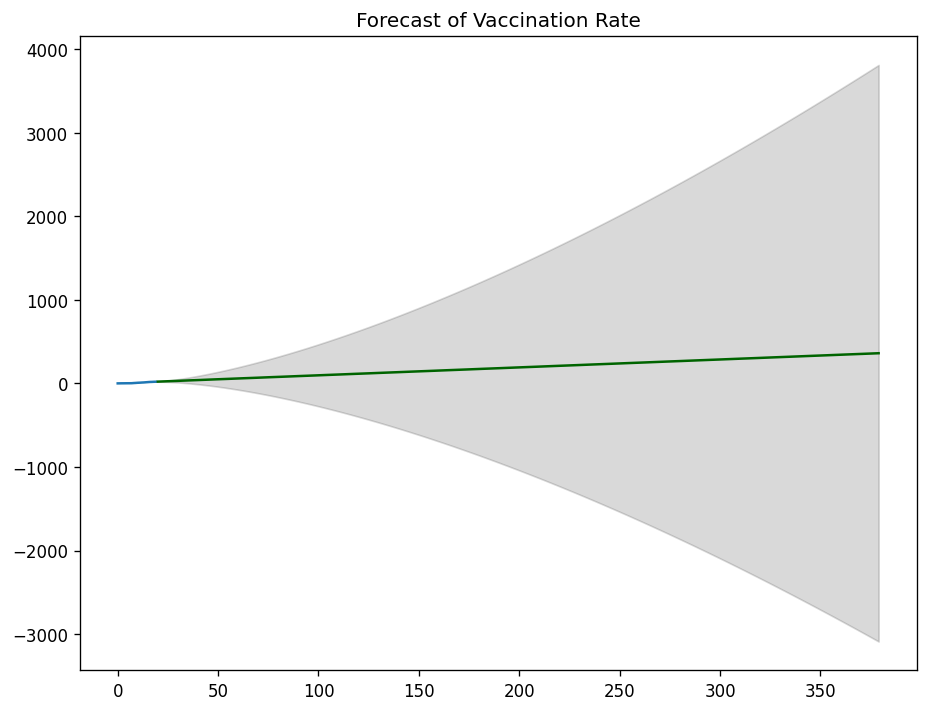

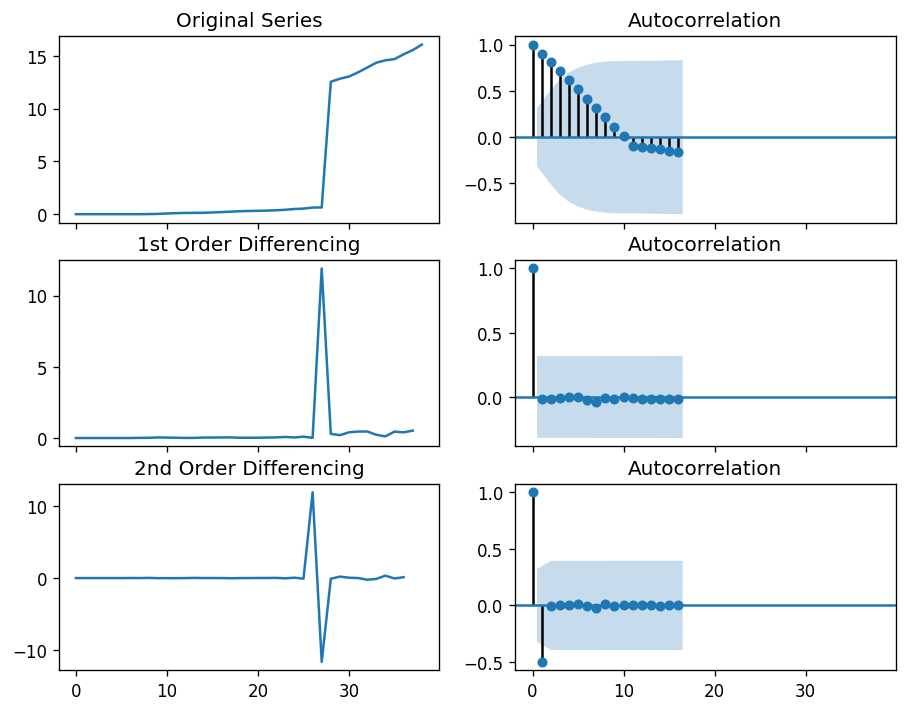

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=183.385, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=175.055, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=181.386, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=172.716, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=172.332, Time=0.05 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=172.905, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=170.339, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=170.721, Time=0.02 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=170.915, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=166.793, Time=0.08 sec
 A

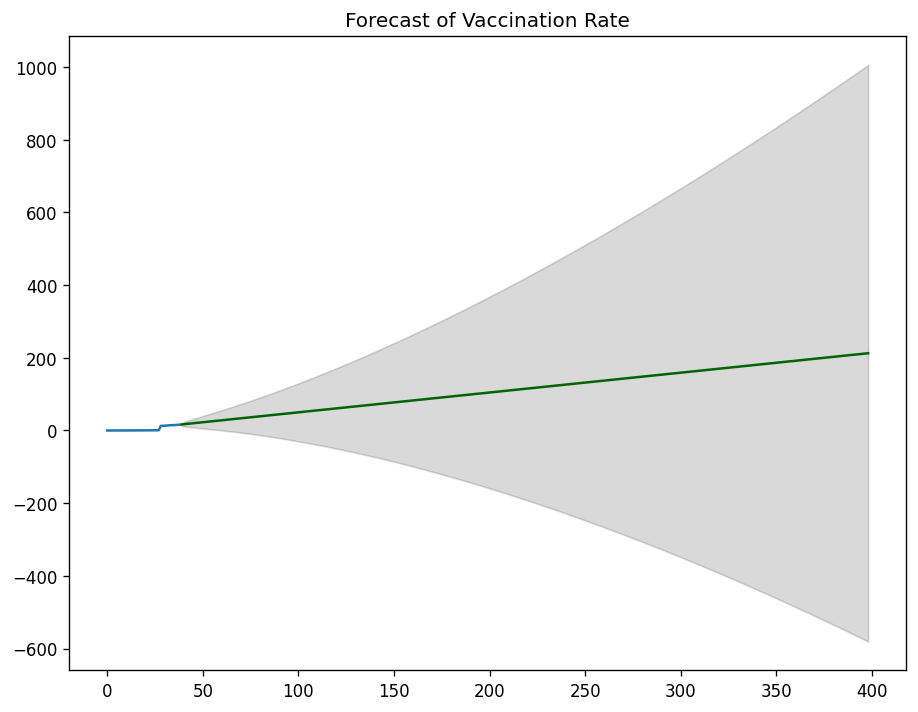

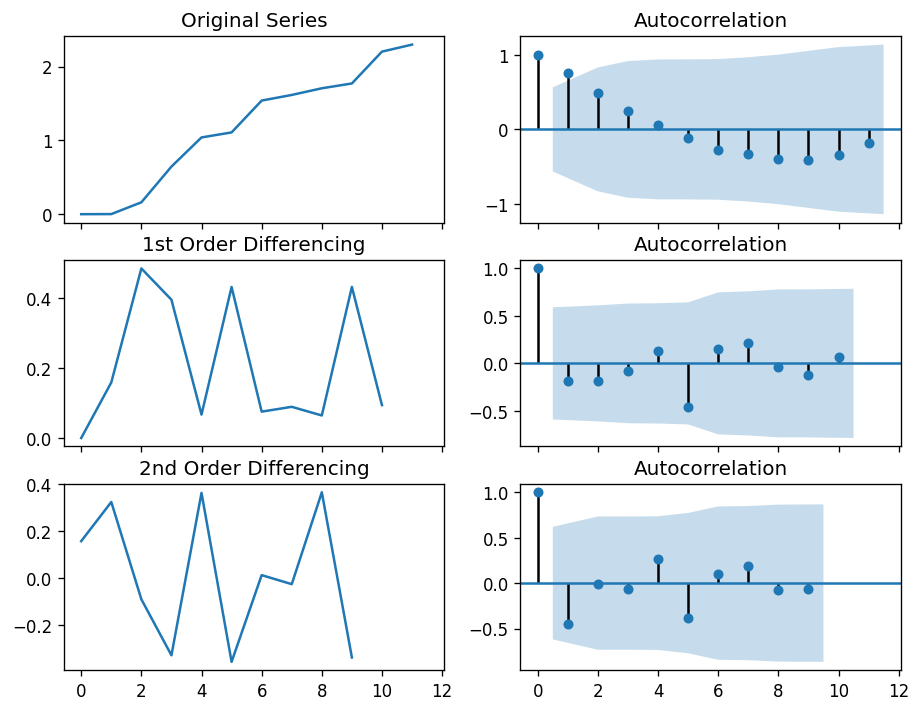

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6.485, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5.939, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4.497, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.366 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   12
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  -1.248
Date:                Fri, 04 Jun 2021   AIC                              4.497
Time:                        21:03:09   BIC                              4.799
Sample:                             0   HQIC                             4.165
                                 - 12                                         
Covariance Type:

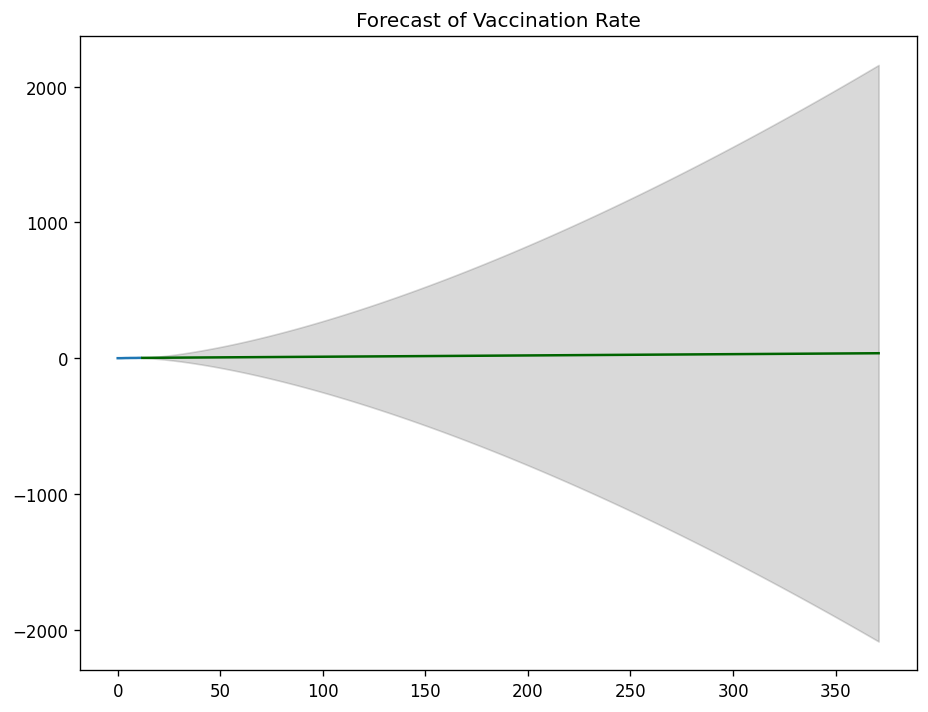

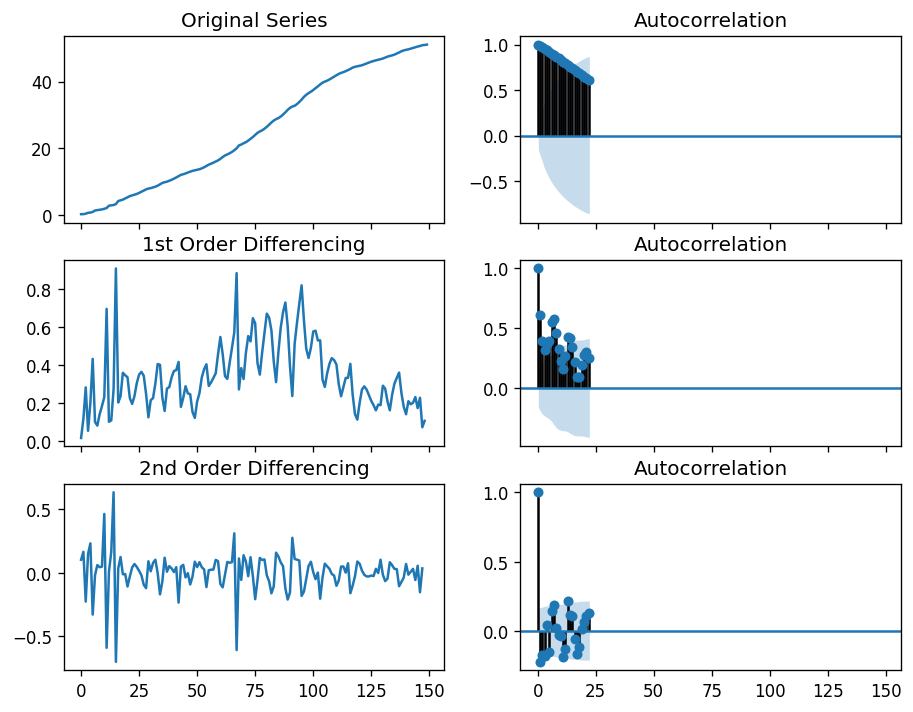

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-178.723, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-141.086, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-146.503, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-169.985, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-143.084, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-182.700, Time=0.32 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-153.080, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-187.196, Time=0.32 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-166.393, Time=0.11 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-187.279, Time=0.42 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-169.389, Time=0.17 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=-183.203, Time=0.68 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-184.018, Time=0.44 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-189.276, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0]          

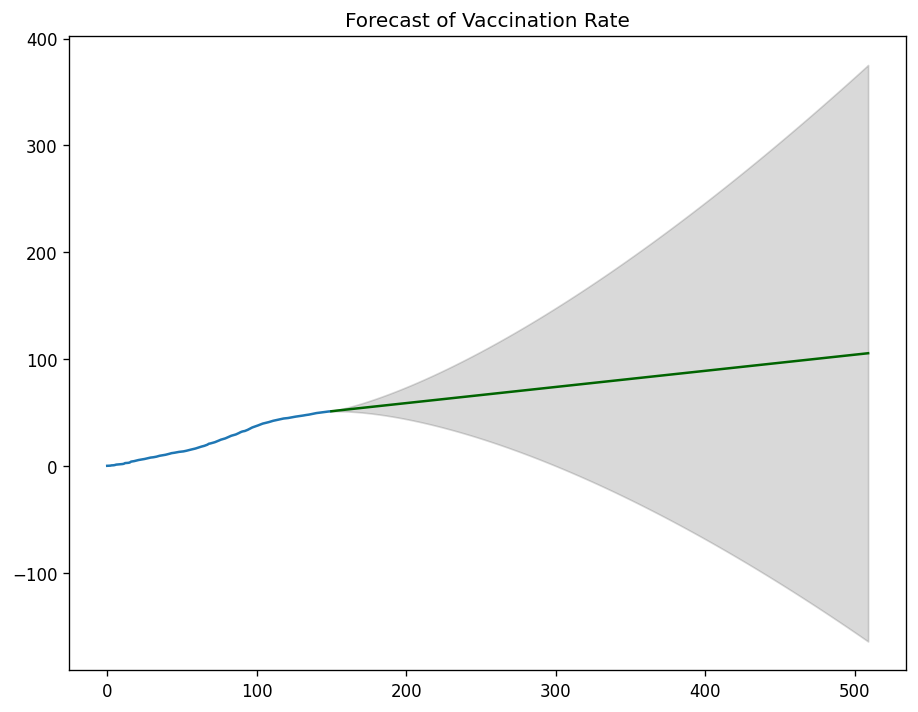

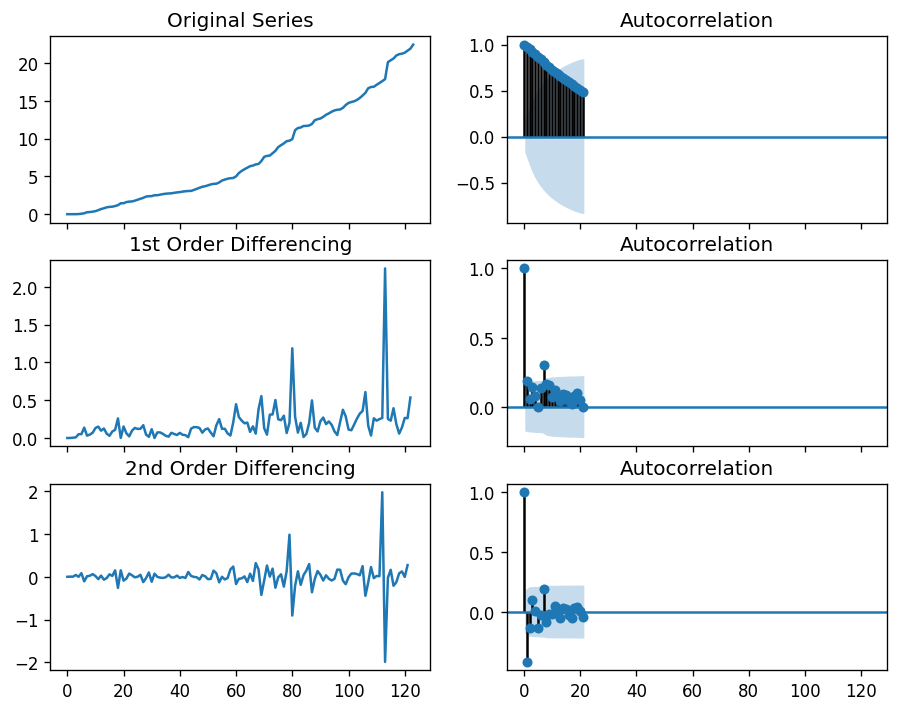

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1.436, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.583, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3.052, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3.200, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.259, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=0.197, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=0.052, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5.182, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4.990, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=0.687, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1.606, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=38.020, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=28.255, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-0.010, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-0.115, Time=0.18 sec
 ARIM

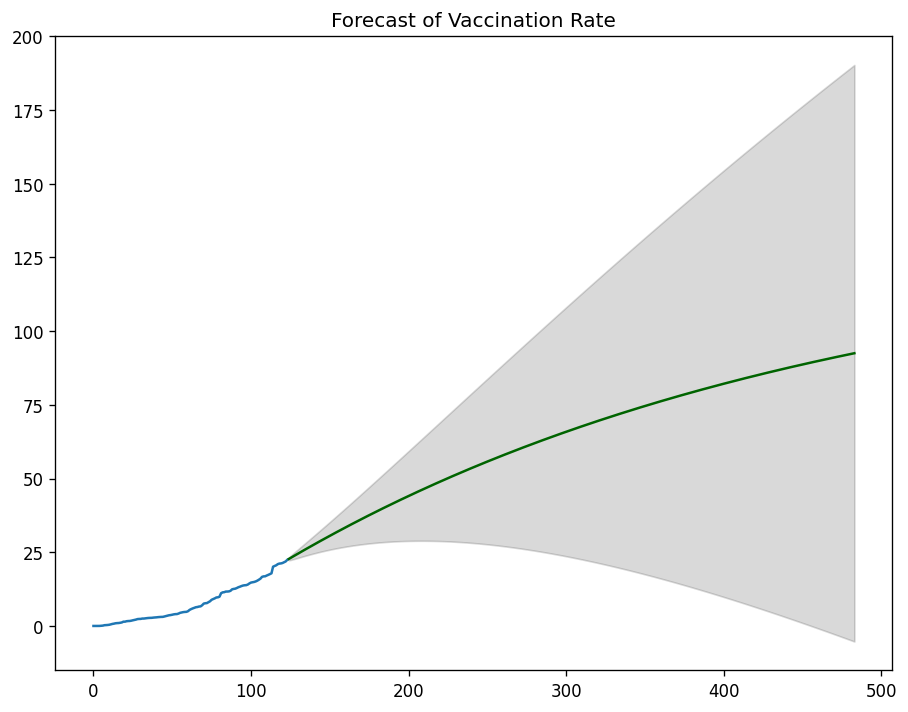

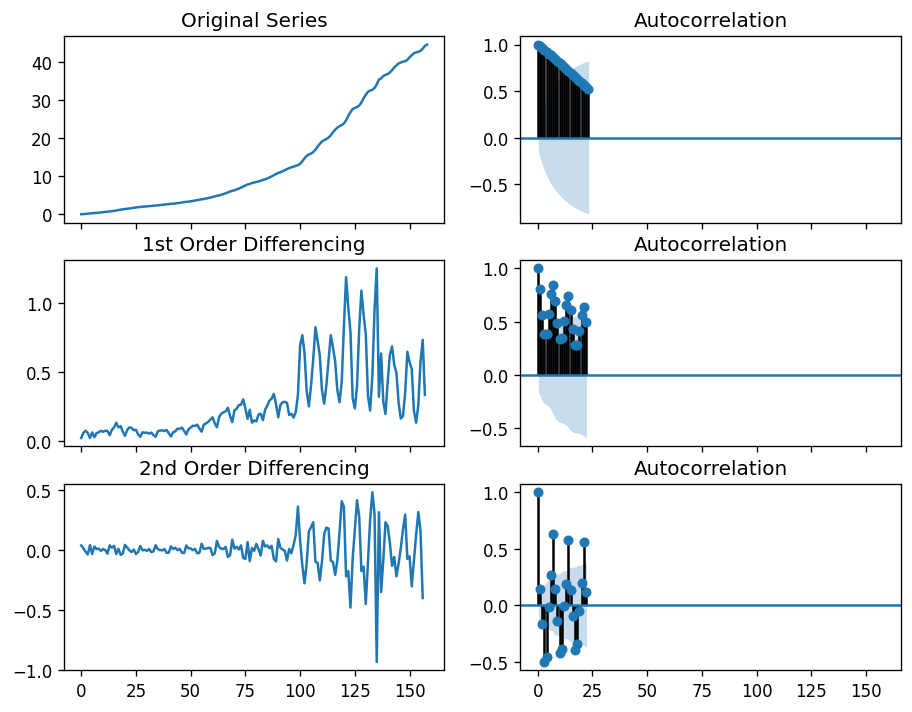

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-123.270, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-123.183, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-124.357, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-125.226, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-125.159, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-155.092, Time=0.29 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-160.524, Time=0.41 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-229.421, Time=0.58 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-185.072, Time=0.32 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-244.789, Time=0.60 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-221.848, Time=0.40 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=-215.418, Time=0.82 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=-222.681, Time=0.80 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-248.899, Time=0.61 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept

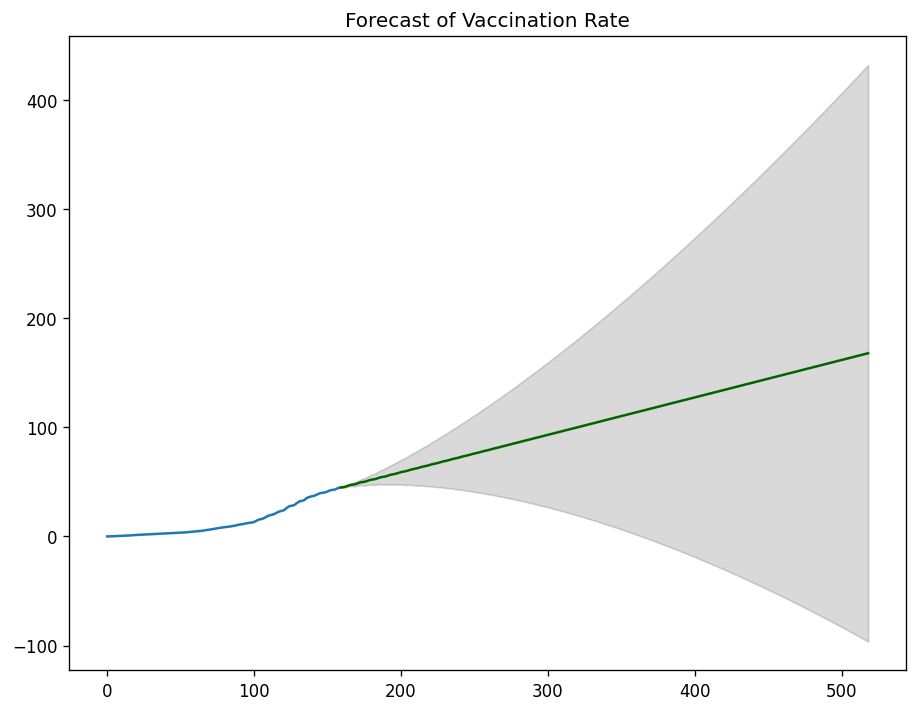

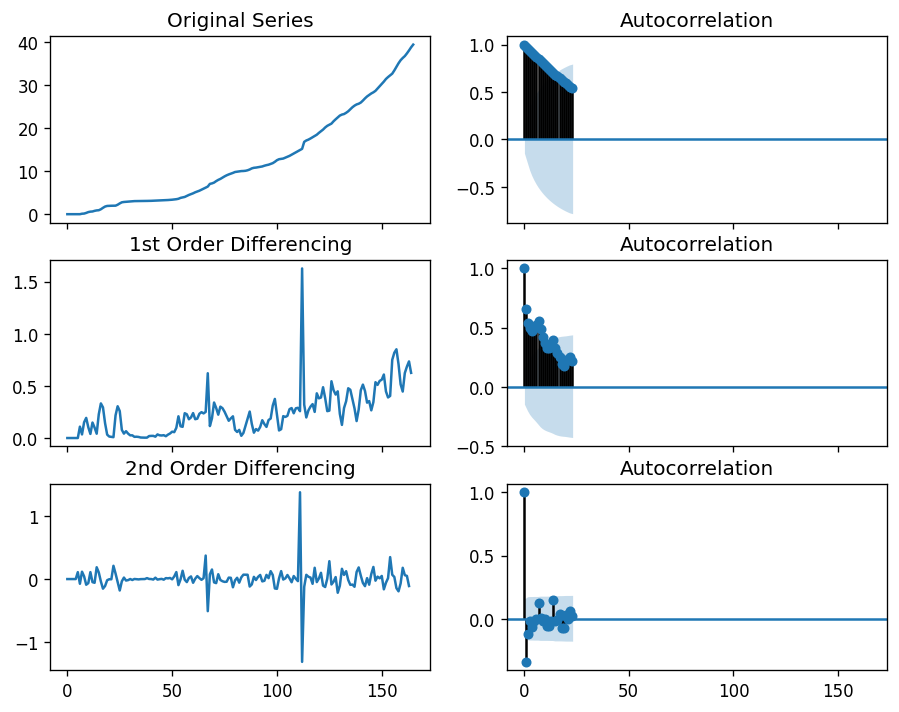

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-153.275, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-97.407, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-115.552, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-149.359, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-99.331, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-152.151, Time=0.31 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-151.841, Time=0.43 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-153.837, Time=0.21 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-151.843, Time=0.50 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-150.928, Time=0.55 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-152.928, Time=0.07 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0] intercept
Total fit time: 2.533 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  16

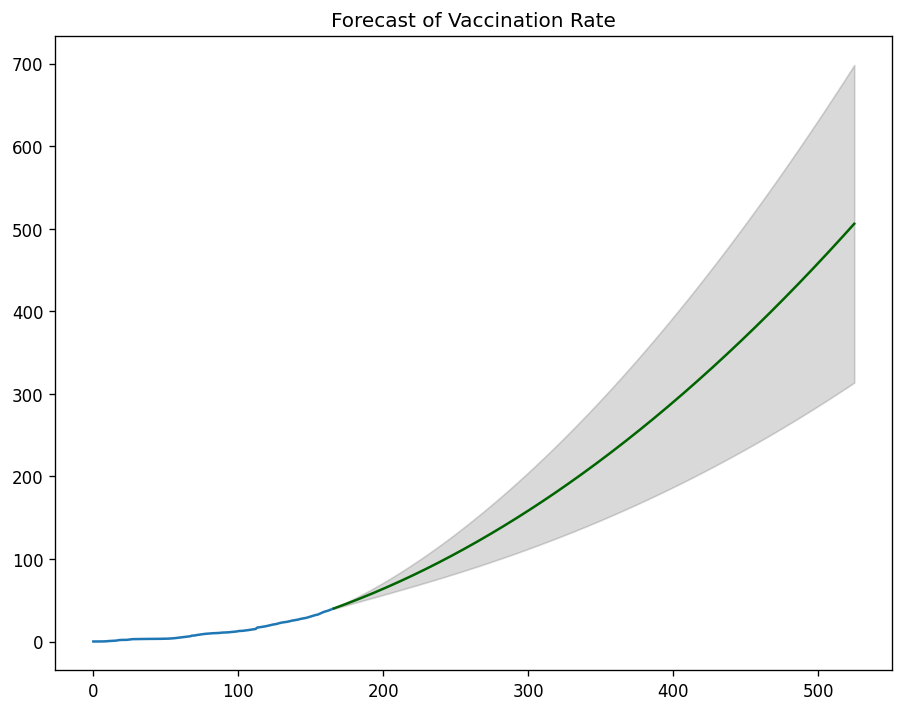

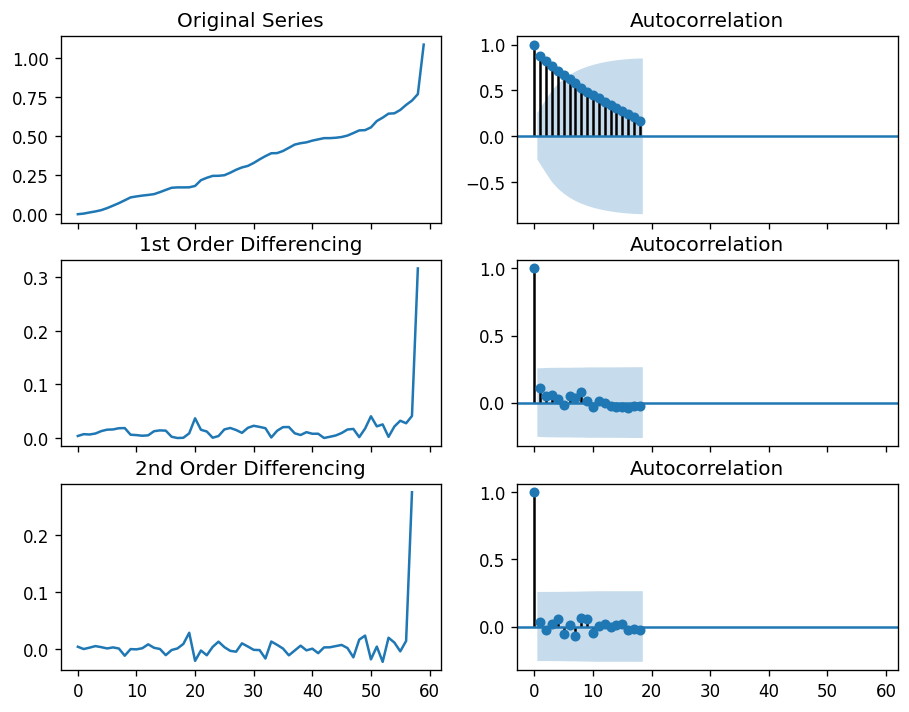

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-210.476, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-213.555, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-212.198, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-212.462, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-214.341, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.483 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 108.171
Date:                Fri, 04 Jun 2021   AIC                           -214.341
Time:                        21:03:41   BIC                           -212.281
Sample:                             0   HQIC                          -213.539
                                 - 60                                       

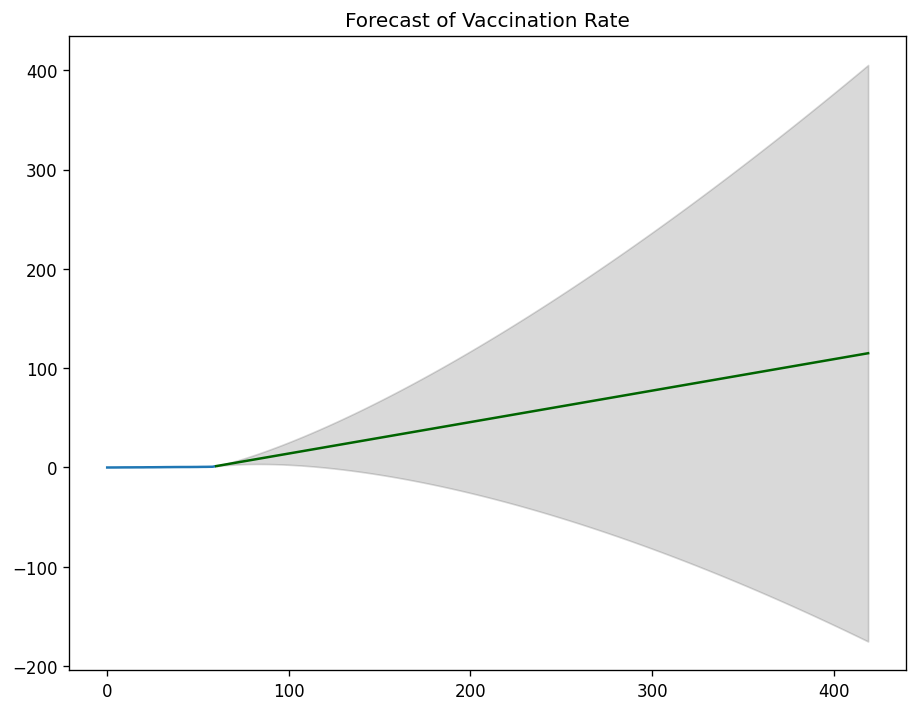

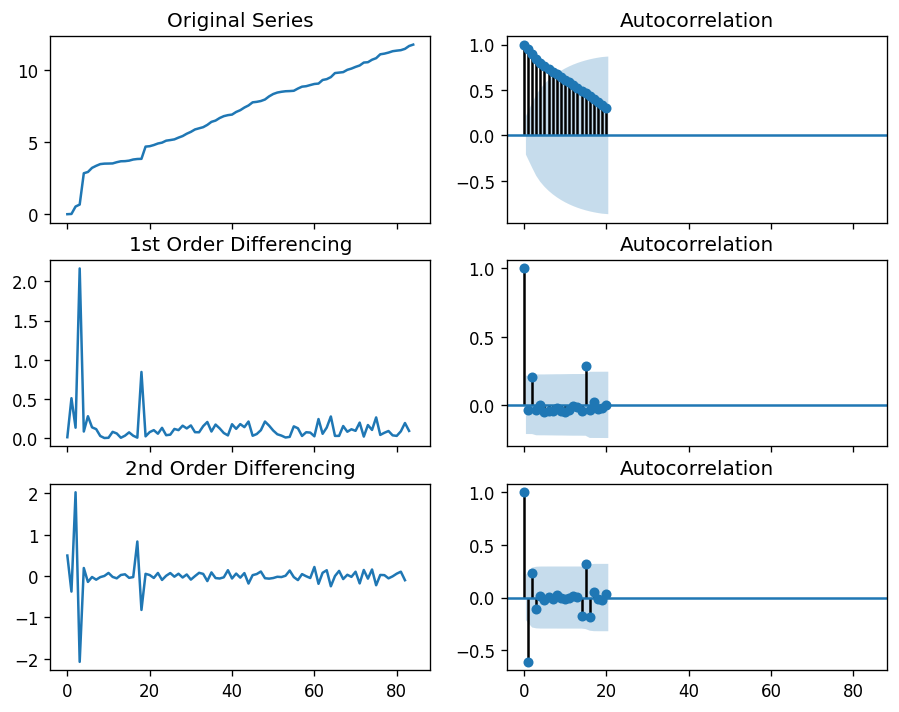

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11.484, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9.179, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.070, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11.101, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30.039, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.406 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  -2.590
Date:                Fri, 04 Jun 2021   AIC                              9.179
Time:                        21:03:43   BIC                             14.041
Sample:                             0   HQIC                            11.134
                                 - 85                                         
Covarian

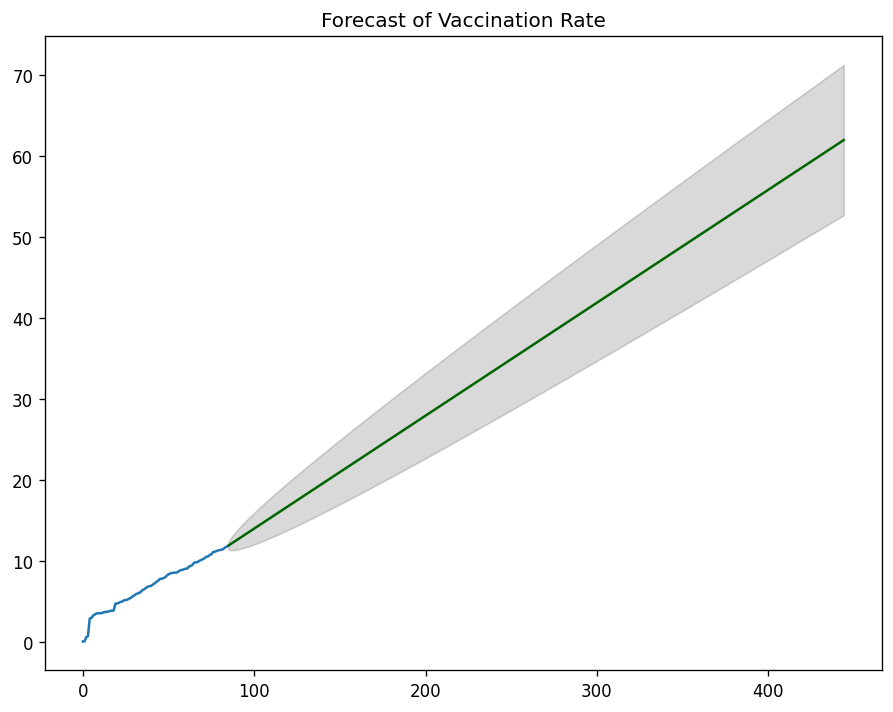

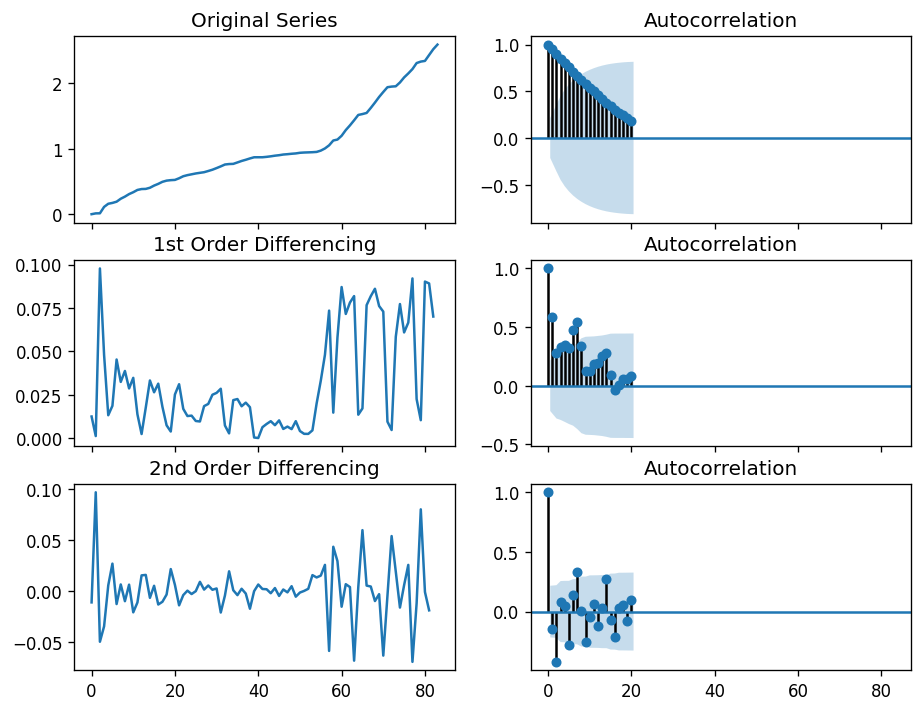

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-382.110, Time=0.35 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-364.072, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-363.938, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-377.255, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-366.010, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-389.544, Time=0.50 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-384.657, Time=0.15 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-387.561, Time=0.38 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-388.995, Time=0.34 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-388.154, Time=0.14 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-382.855, Time=0.29 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-386.645, Time=0.48 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-391.199, Time=0.18 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-383.371, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[0]          

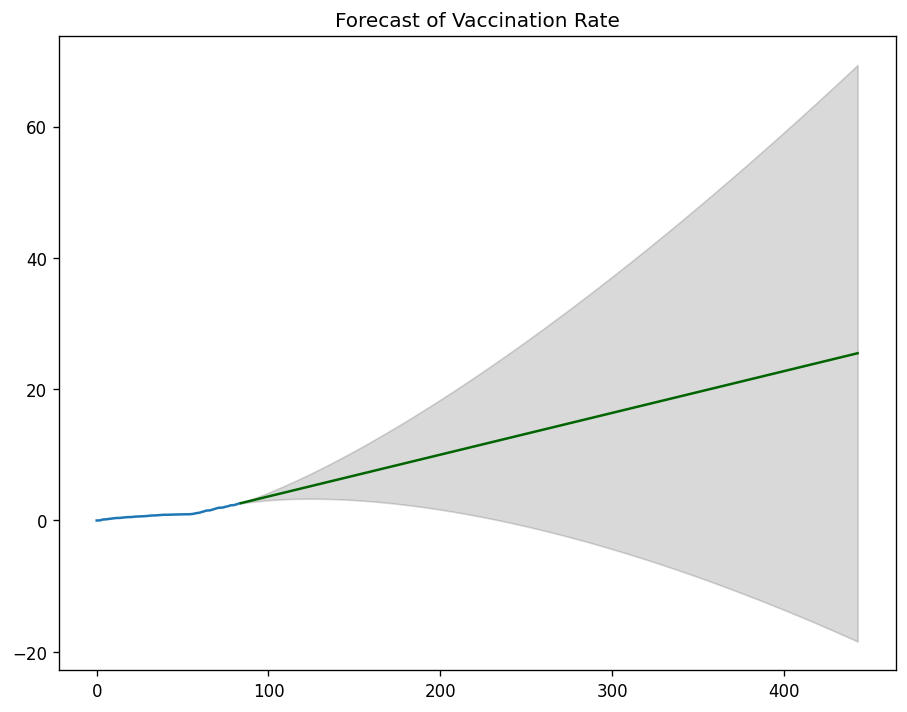

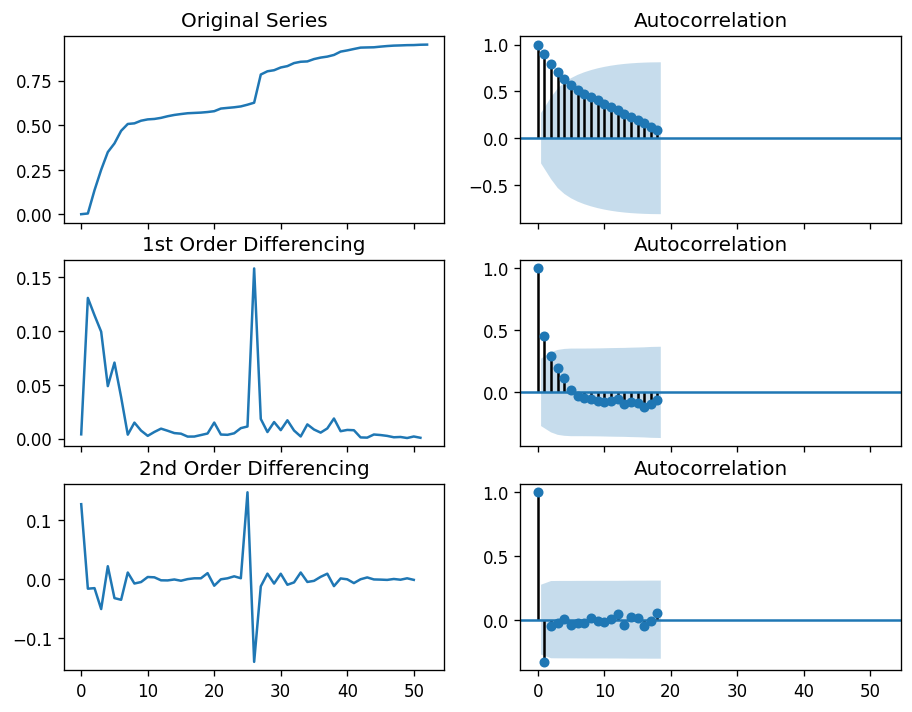

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-209.276, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-200.637, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-210.496, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-207.573, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189.283, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-209.224, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-207.300, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-208.252, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.873 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   53
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 108.248
Date:                Fri, 04 Jun 2021   AIC                           -210.496
Time:                        21:03:5

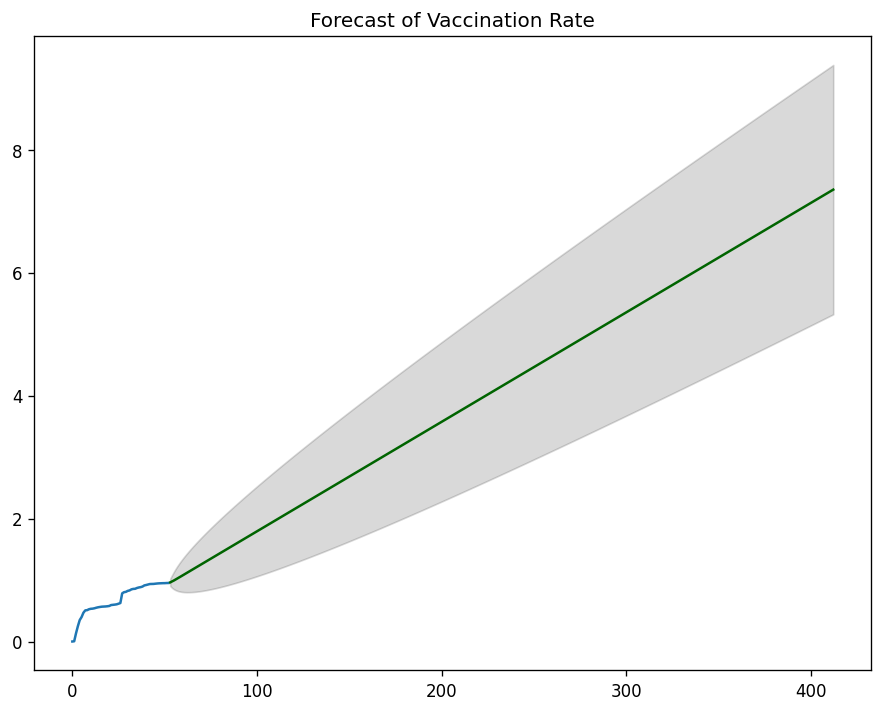

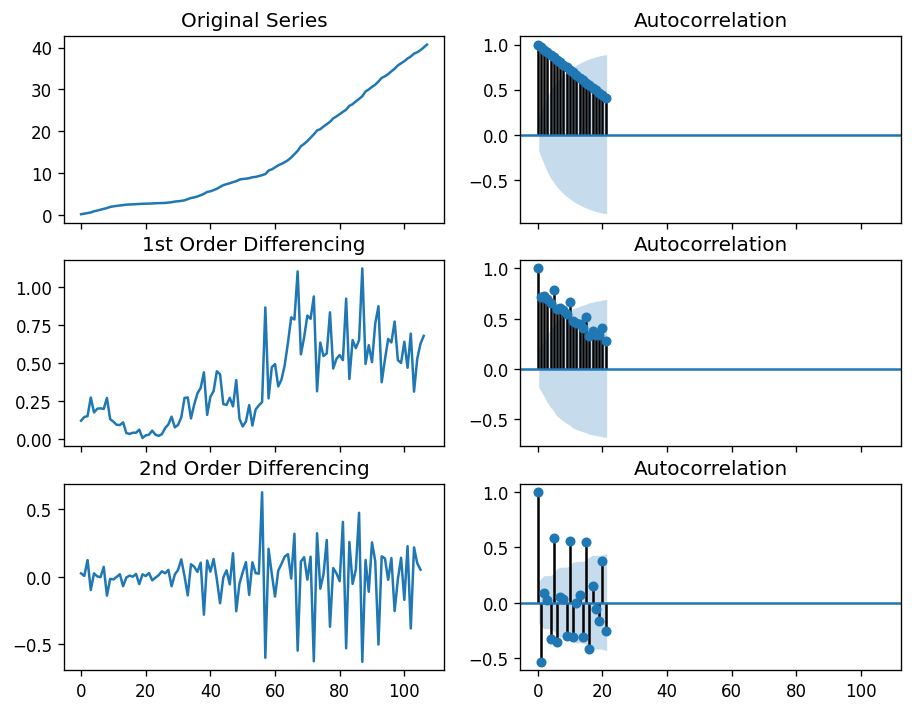

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-80.117, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-32.388, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-66.022, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-81.074, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-34.317, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-80.141, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-82.221, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-81.368, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-81.413, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-67.808, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.28 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.516 seconds
                               SARIMAX Results                                
Dep. Variable:               

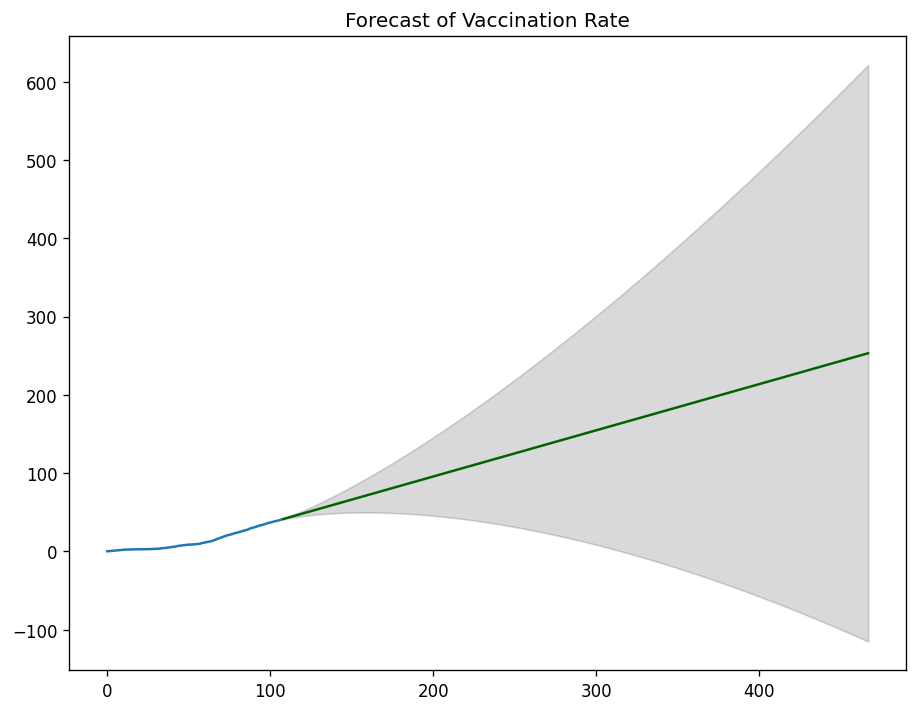

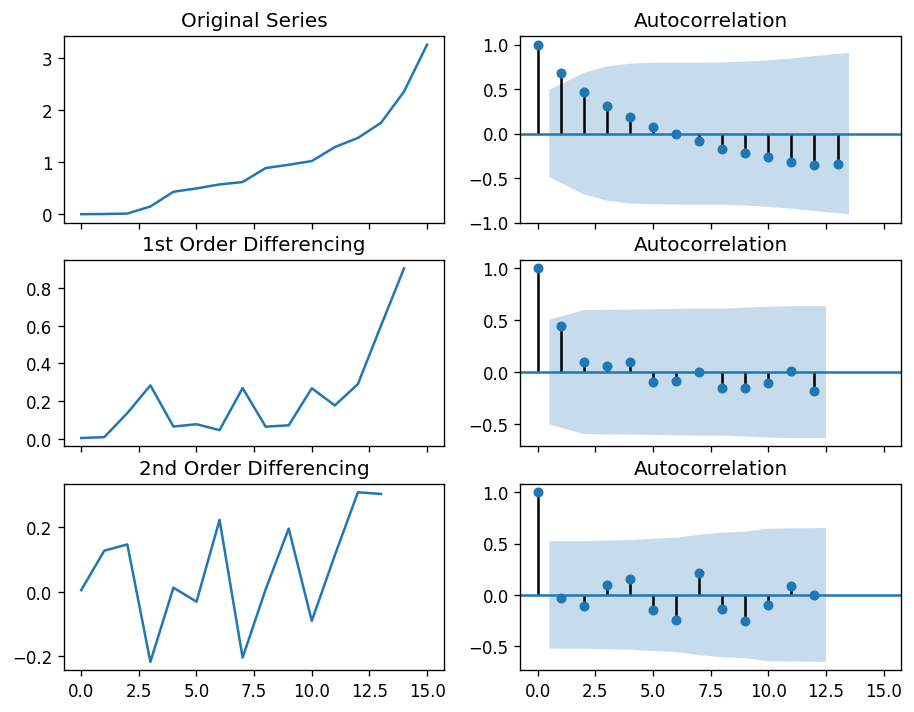

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-3.819, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-7.164, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-5.175, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-5.179, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-7.124, Time=0.03 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0] intercept
Total fit time: 0.481 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   16
Model:               SARIMAX(0, 2, 0)   Log Likelihood                   5.582
Date:                Fri, 04 Jun 2021   AIC                             -7.164
Time:                        21:03:57   BIC                             -5.886
Sample:                             0   HQIC                            -7.283
                                 - 16                                         
Covaria

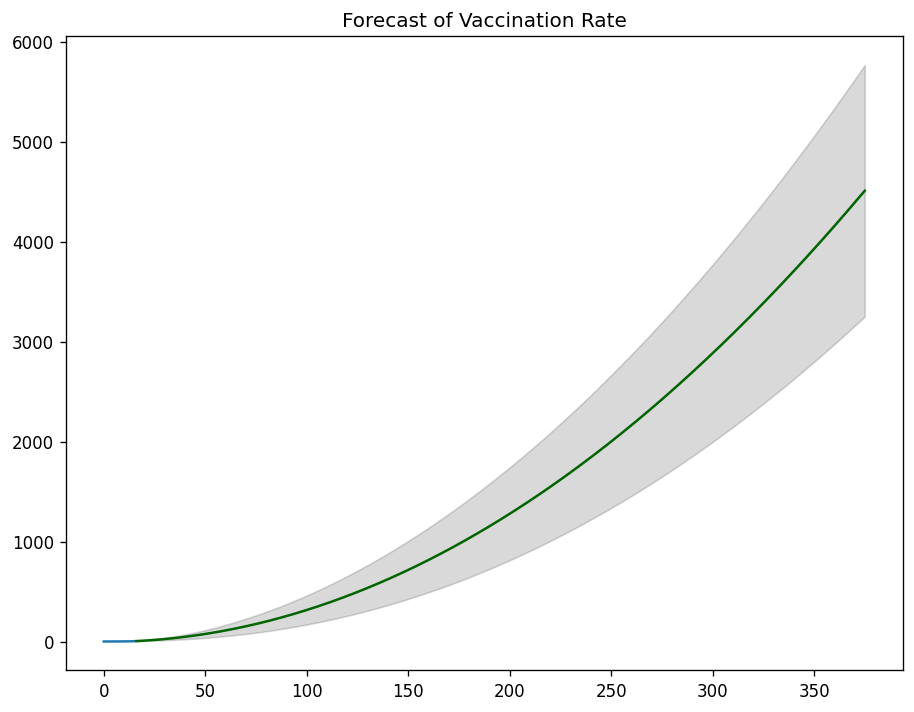

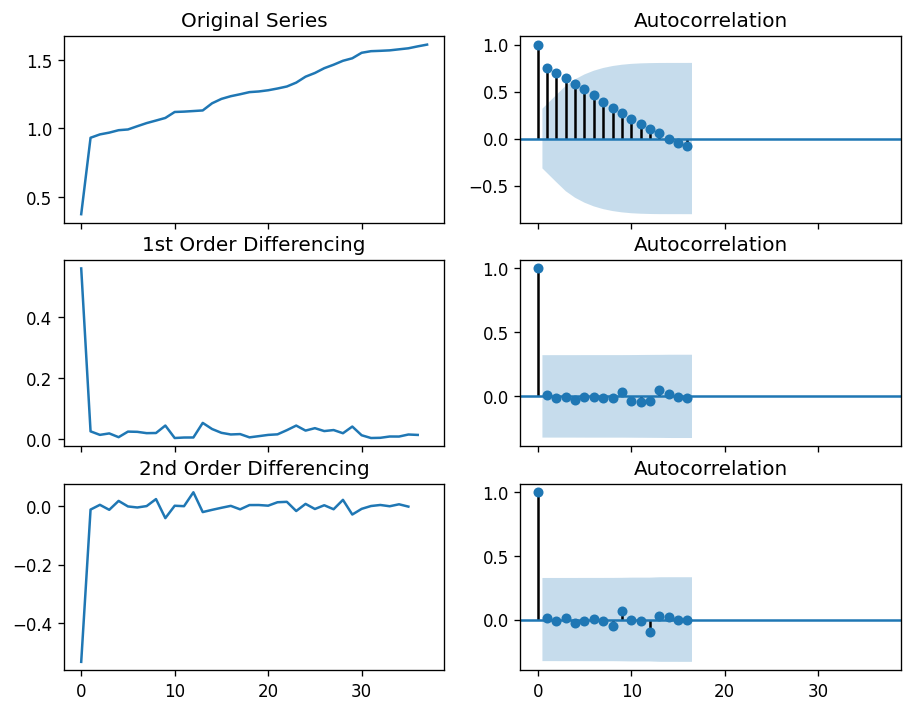

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-64.113, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-68.067, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-66.125, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-66.160, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-69.038, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.832 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  35.519
Date:                Fri, 04 Jun 2021   AIC                            -69.038
Time:                        21:03:59   BIC                            -67.454
Sample:                             0   HQIC                           -68.485
                                 - 38                                         
Co

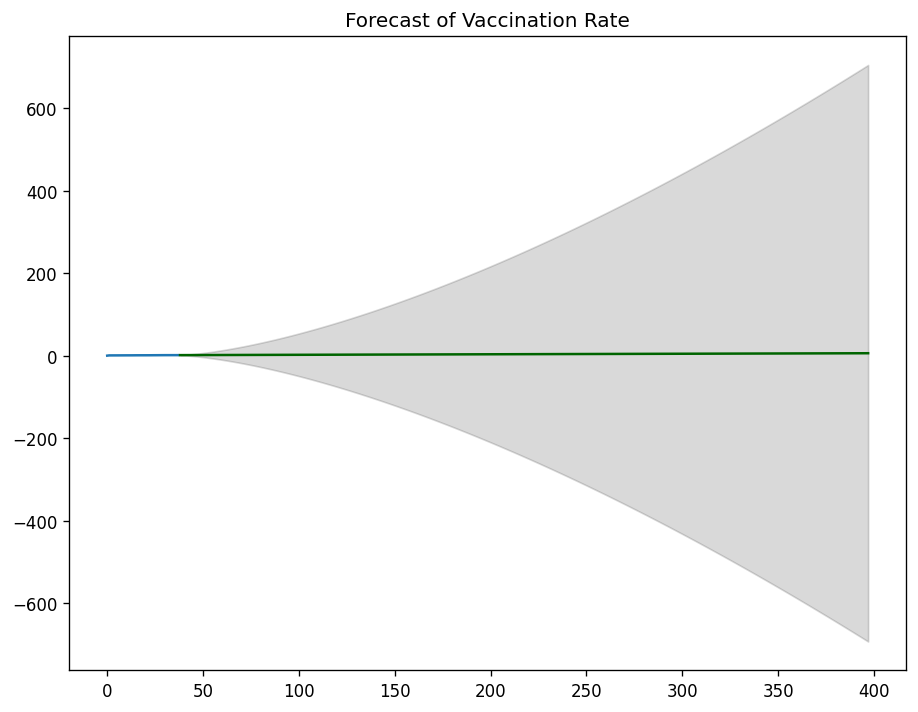

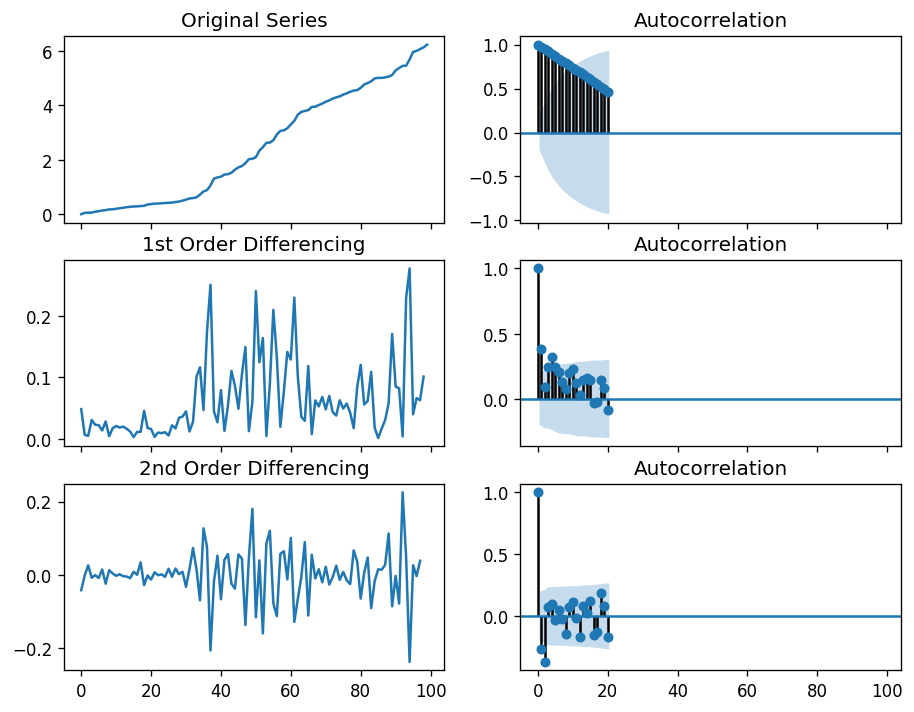

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-278.138, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-242.722, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-247.572, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-276.990, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-244.716, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-283.196, Time=0.26 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-269.503, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-281.482, Time=0.41 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-281.458, Time=0.18 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-274.510, Time=0.16 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-279.535, Time=0.41 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-284.587, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-279.144, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : 

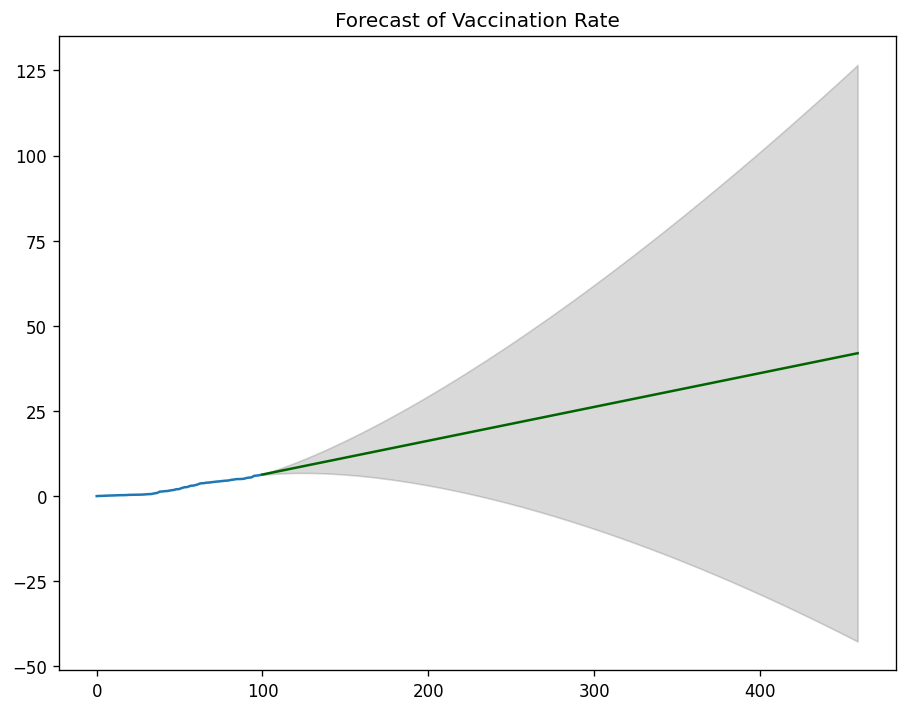

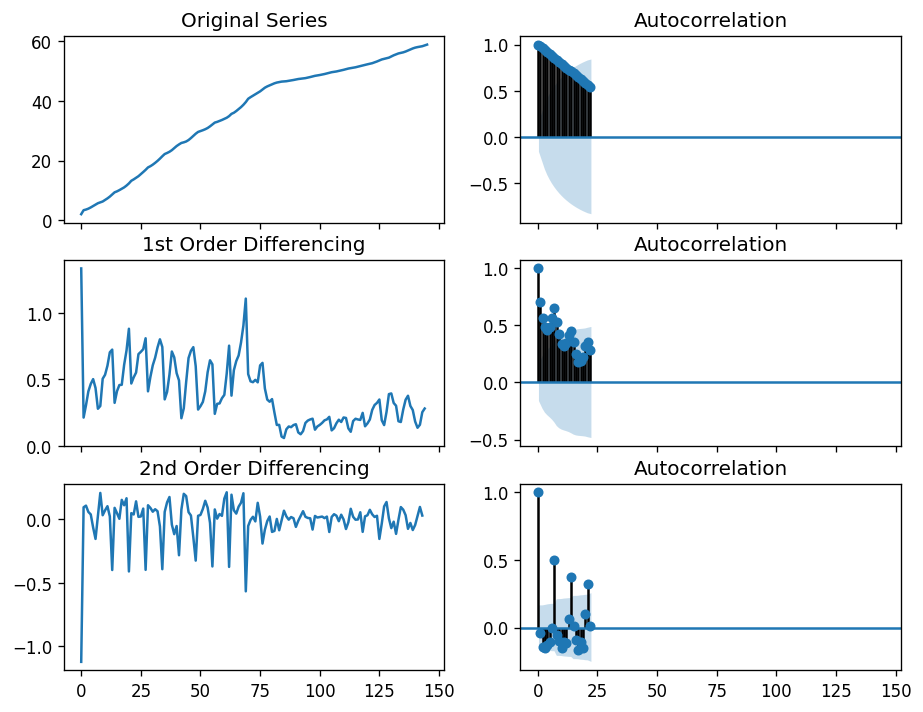

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-118.406, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-116.748, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-117.080, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-120.098, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.704 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  146
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  61.049
Date:                Fri, 04 Jun 2021   AIC                           -120.098
Time:                        21:04:07   BIC                           -117.128
Sample:                             0   HQIC                          -118.891
                                - 146                                         
Co

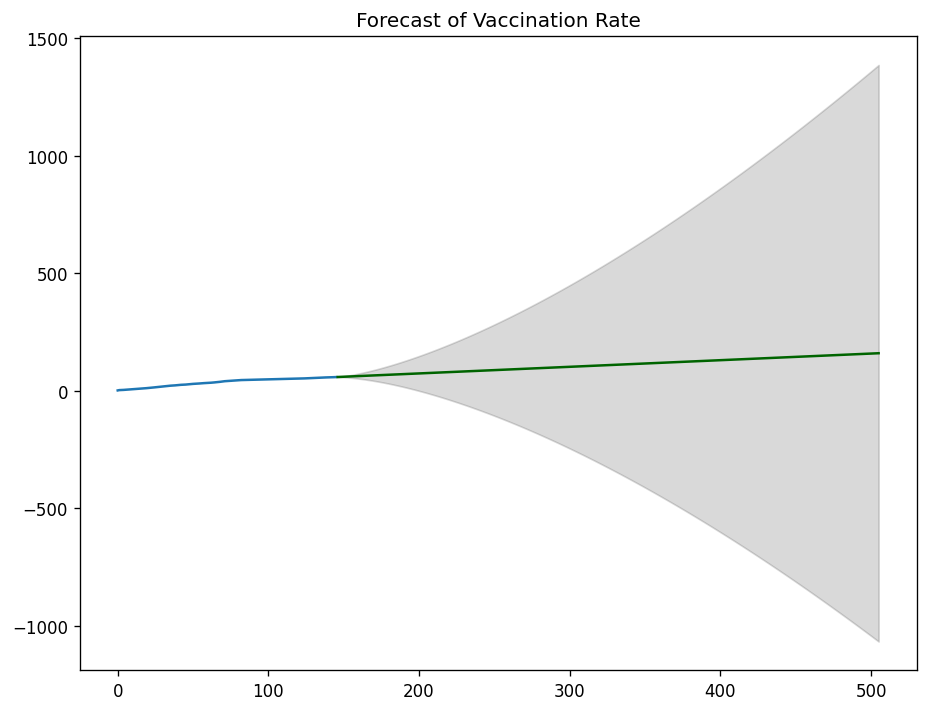

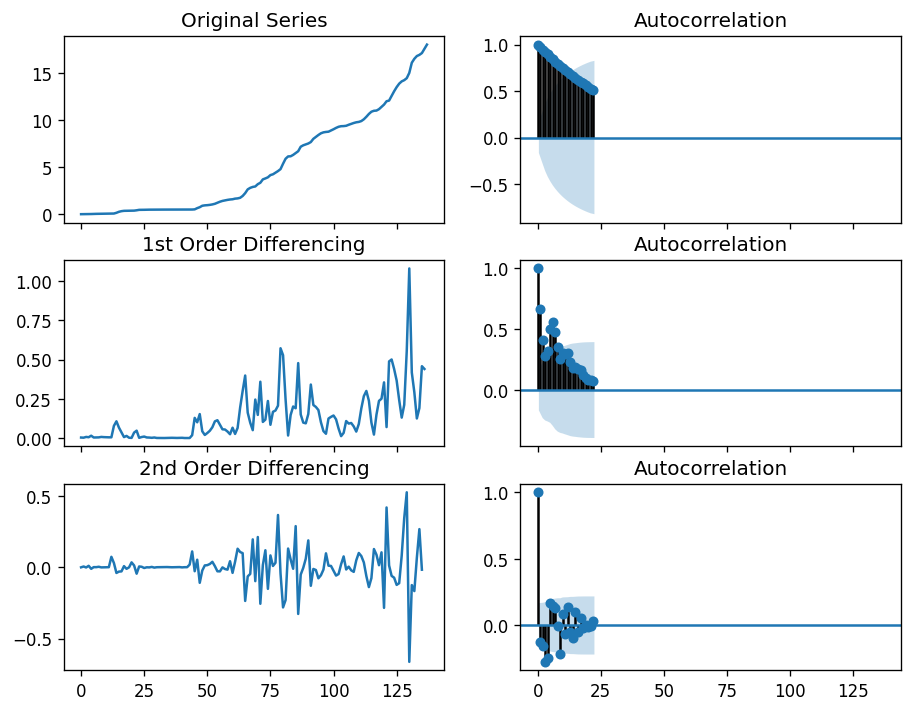

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-167.168, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-167.169, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-177.003, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-169.084, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-199.017, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-198.386, Time=0.40 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-199.121, Time=0.54 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-208.798, Time=0.57 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-208.052, Time=0.51 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=-213.749, Time=0.60 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-198.185, Time=0.62 sec
 ARIMA(4,2,3)(0,0,0)[0] intercept   : AIC=-214.623, Time=0.67 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=-

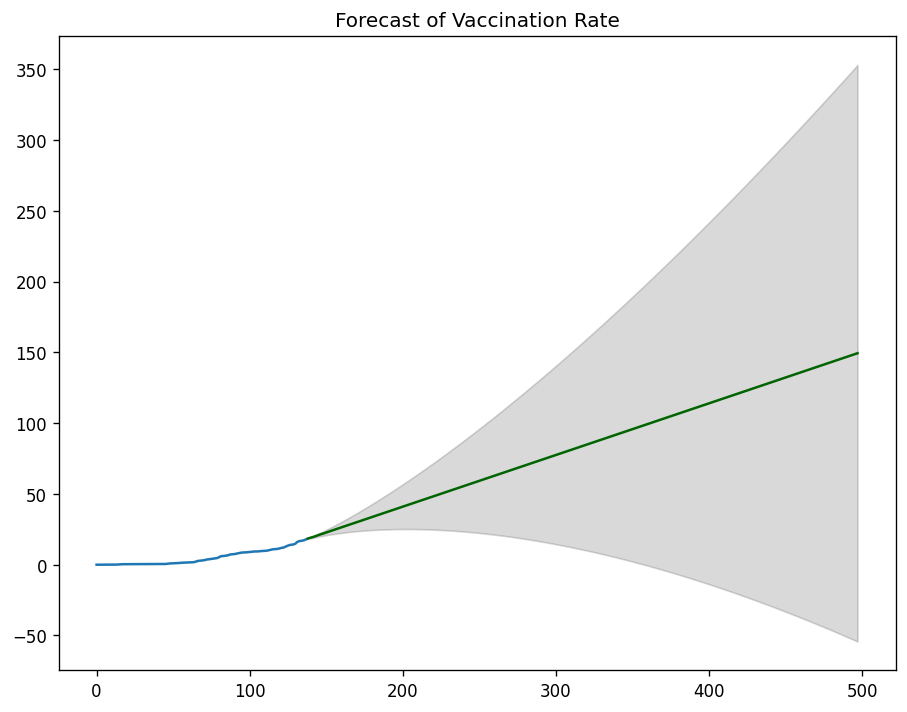

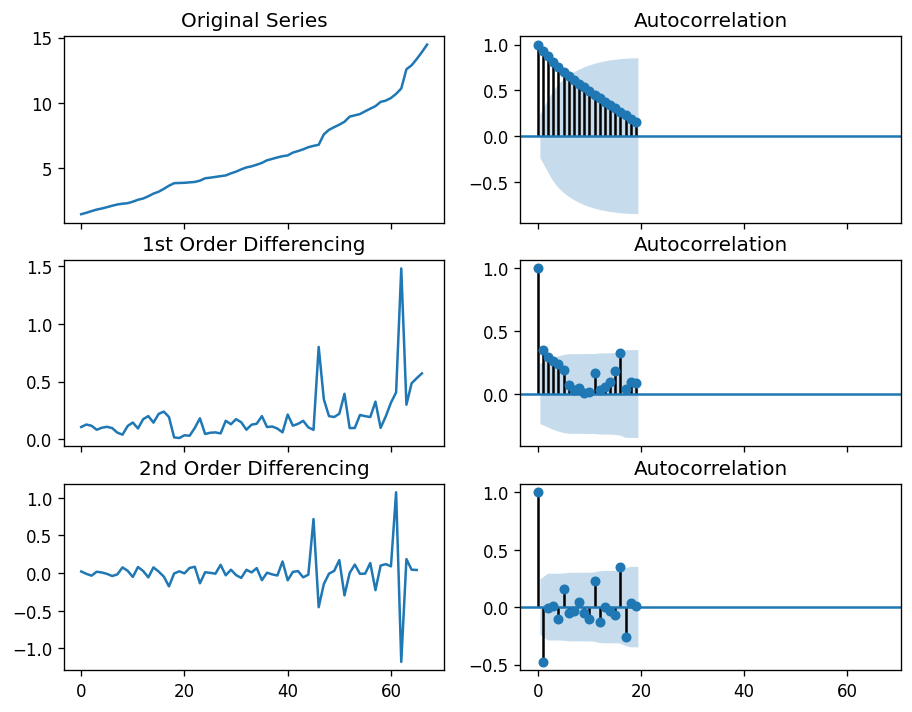

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-26.762, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1.451, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-13.332, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-28.607, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-0.492, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-26.751, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-24.907, Time=0.26 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-28.630, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-26.651, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-26.651, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-15.183, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-24.854, Time=0.17 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.196 seconds
                               SARIMAX Results                                
Dep. Variable:          

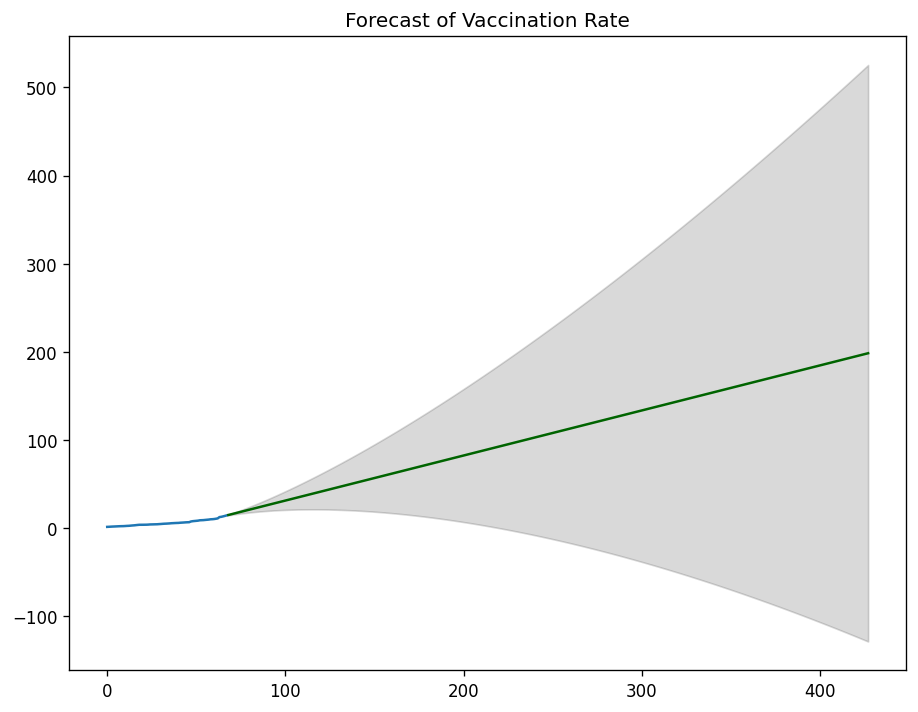

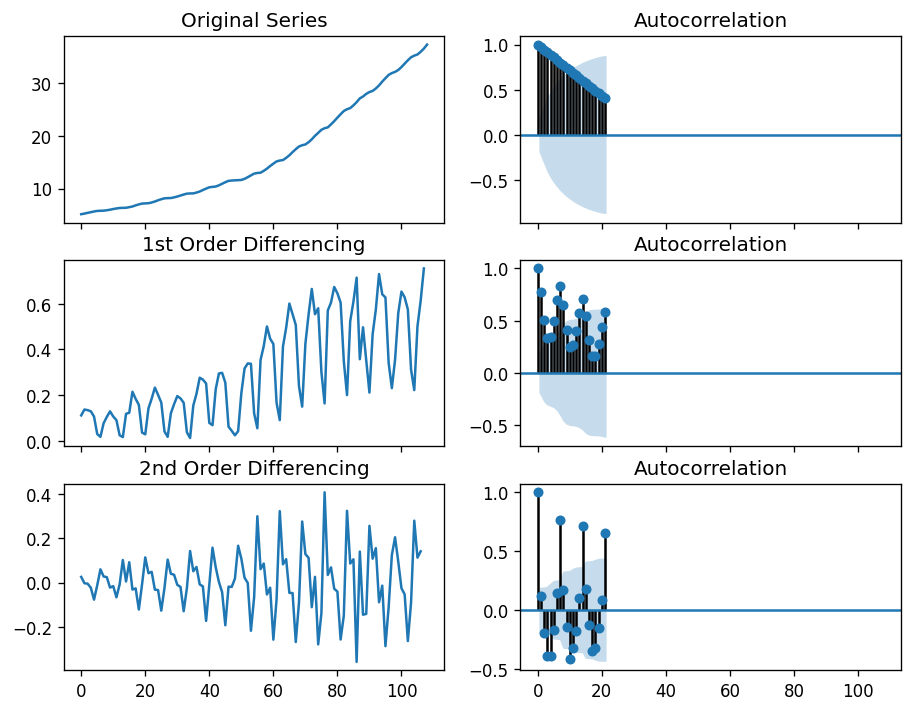

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-132.874, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24.878, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-128.324, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-103.773, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91.067, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-131.322, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-140.371, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-127.915, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-130.534, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-146.315, Time=0.40 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-144.202, Time=0.51 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-146.347, Time=0.47 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-141.011, Time=0.33 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC

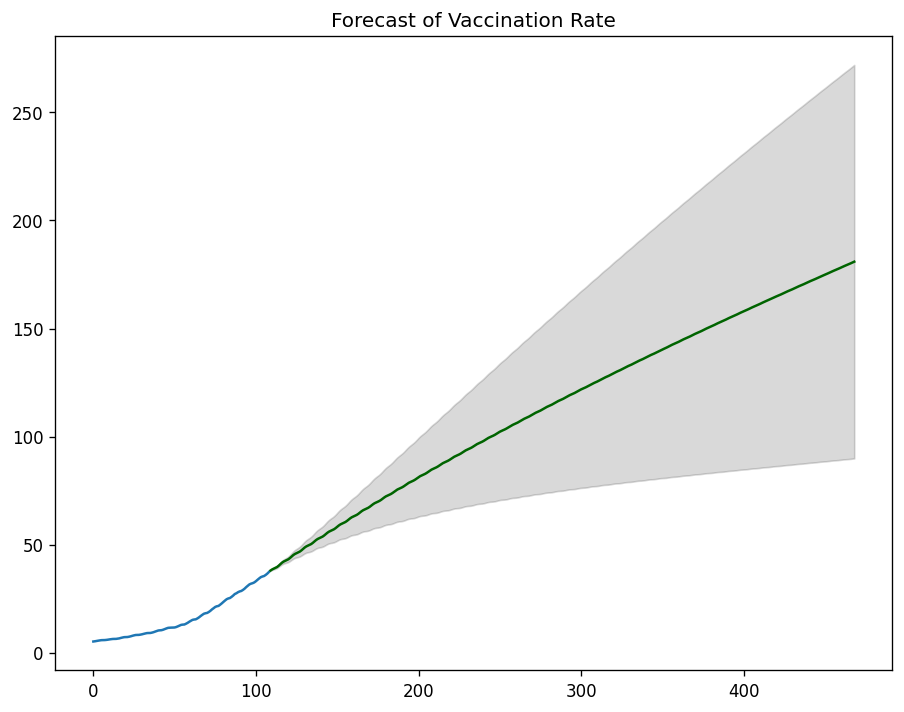

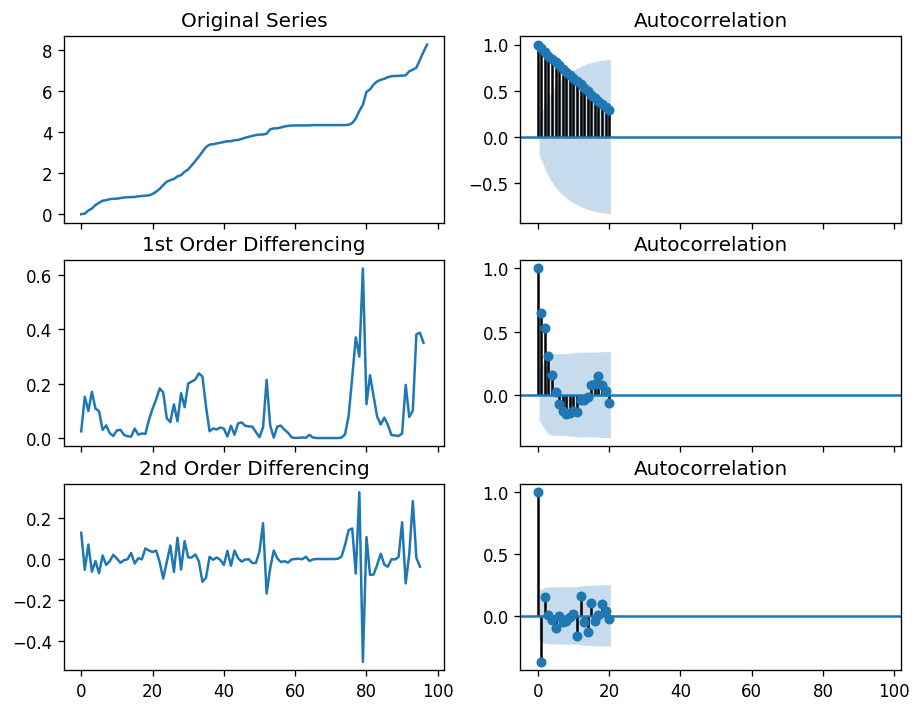

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-208.045, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-151.848, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-206.391, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-180.479, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-107.288, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-208.965, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-210.276, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-209.927, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-211.513, Time=0.42 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-210.771, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-210.225, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-212.302, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-212.452, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-198.273, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept

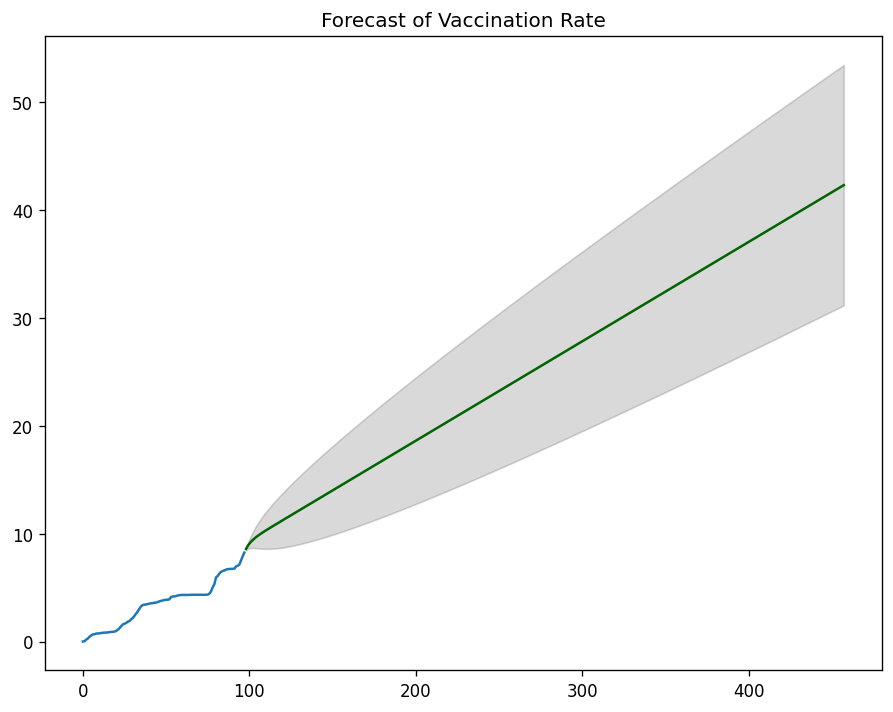

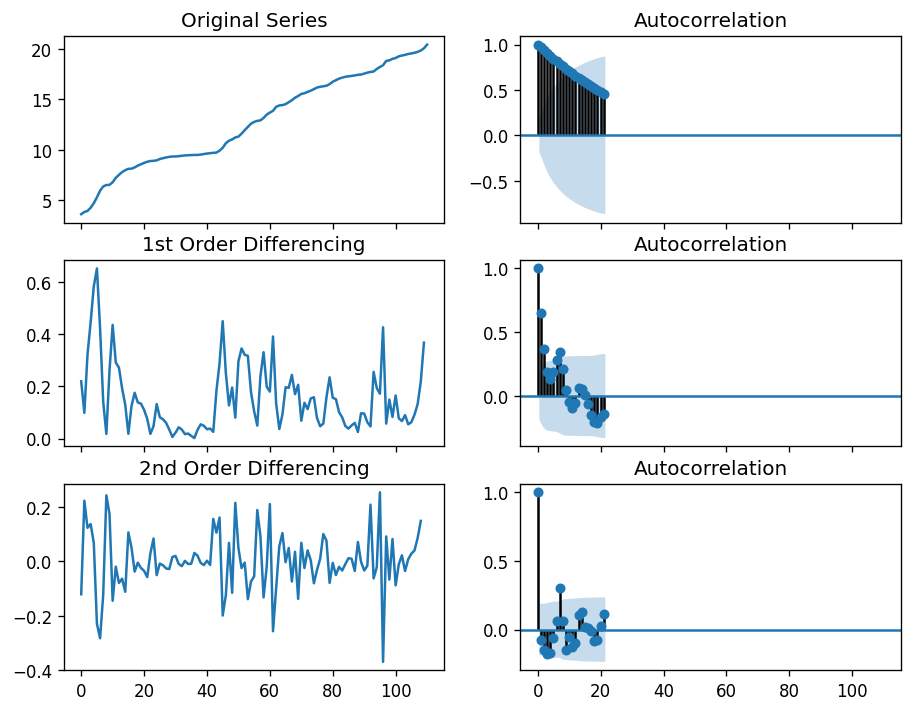

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-176.308, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-174.911, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-175.250, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-178.290, Time=0.03 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.603 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  111
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  90.145
Date:                Fri, 04 Jun 2021   AIC                           -178.290
Time:                        21:04:39   BIC                           -175.599
Sample:                             0   HQIC                          -177.199
                                - 111                                         
Co

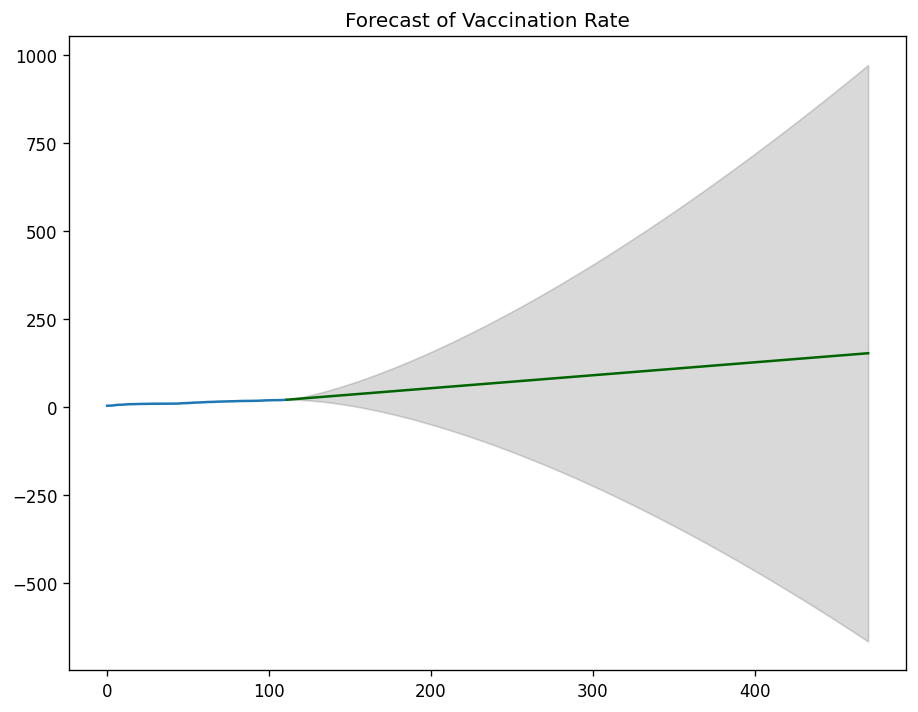

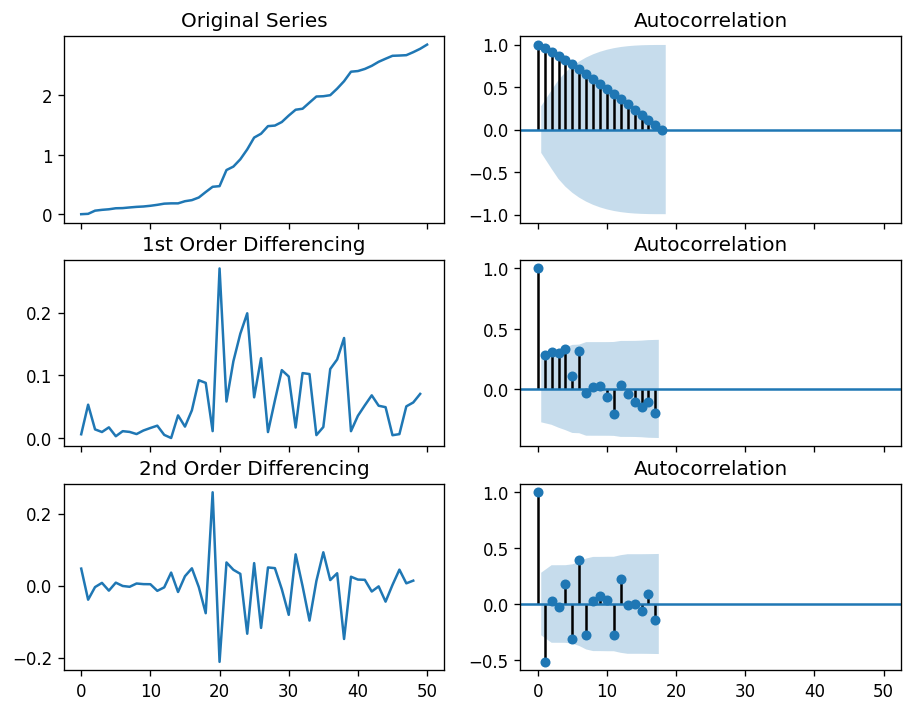

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-138.557, Time=0.23 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-118.364, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-131.530, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-140.166, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-120.346, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-138.642, Time=0.21 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-136.462, Time=0.21 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-142.056, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-140.472, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-140.566, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-133.505, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-138.369, Time=0.22 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.435 seconds
                               SARIMAX Results                                
Dep. Vari

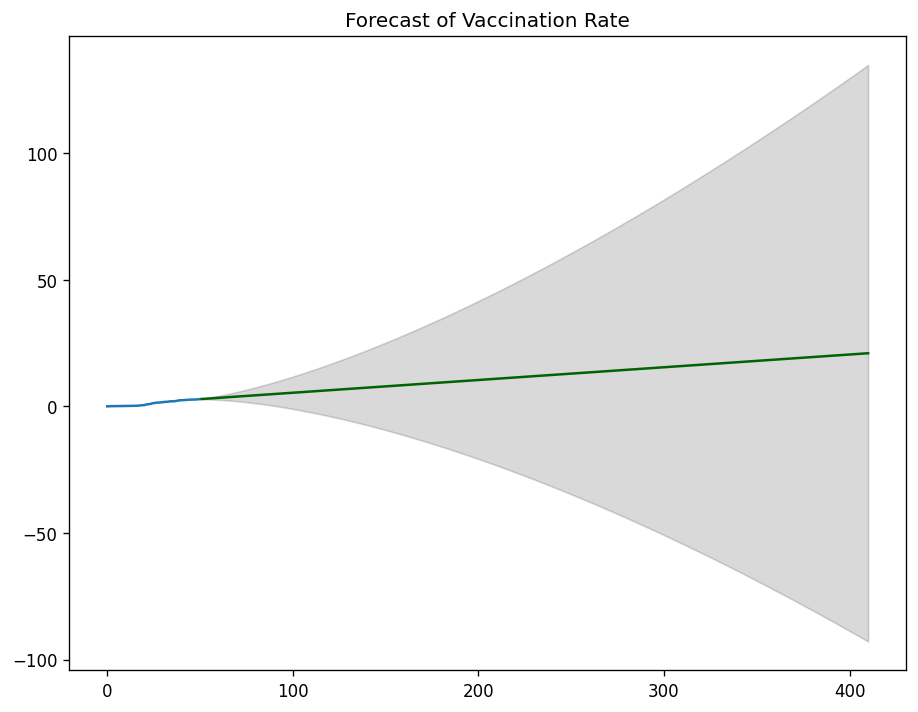

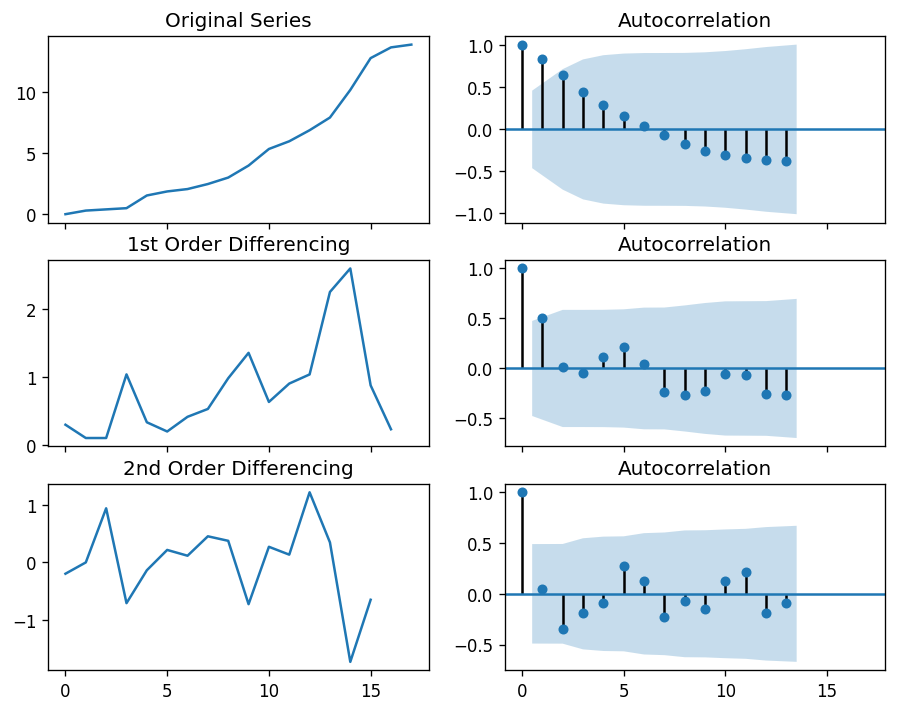

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=37.179, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=39.148, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=39.095, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=35.180, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.323 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   18
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -16.590
Date:                Fri, 04 Jun 2021   AIC                             35.180
Time:                        21:04:43   BIC                             35.953
Sample:                             0   HQIC                            35.220
                                 - 18                                         
Covariance

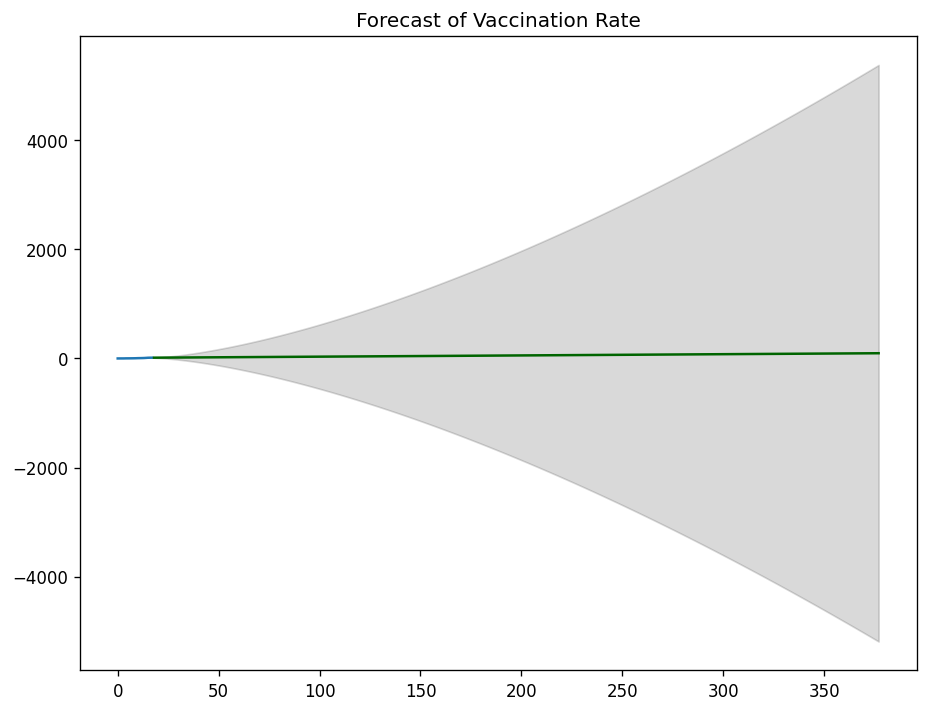

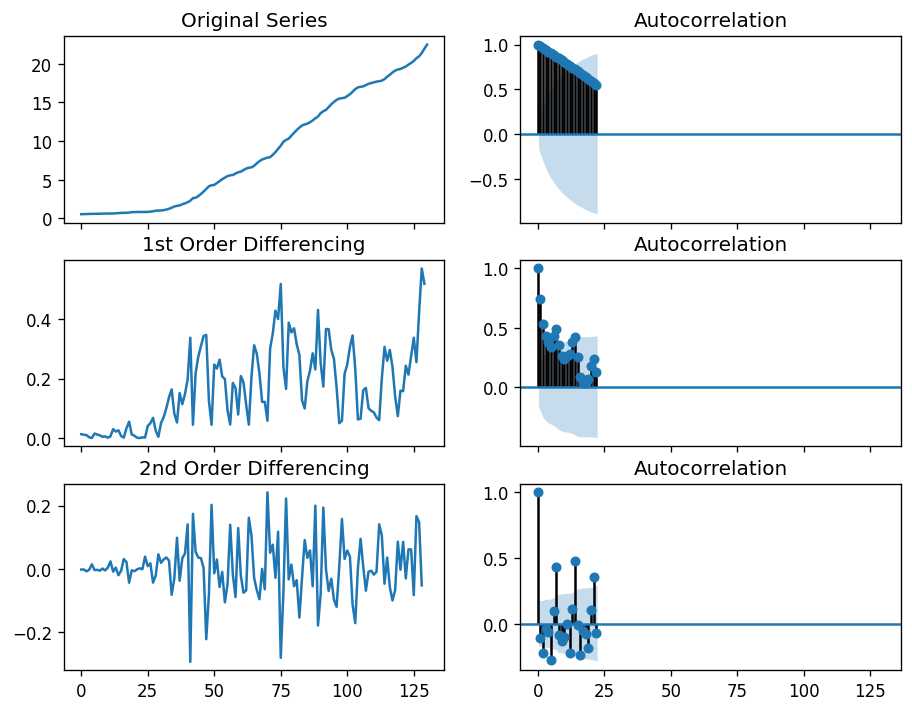

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-253.502, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-252.911, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-254.263, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-255.253, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.590 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  131
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 128.627
Date:                Fri, 04 Jun 2021   AIC                           -255.253
Time:                        21:04:46   BIC                           -252.393
Sample:                             0   HQIC                          -254.091
                                - 131                                         
Co

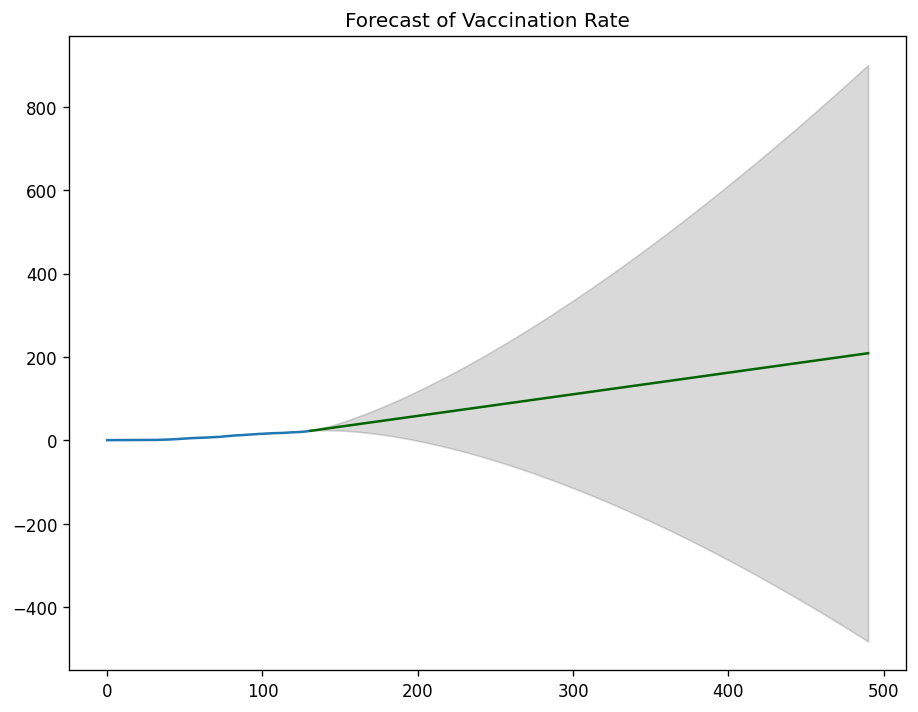

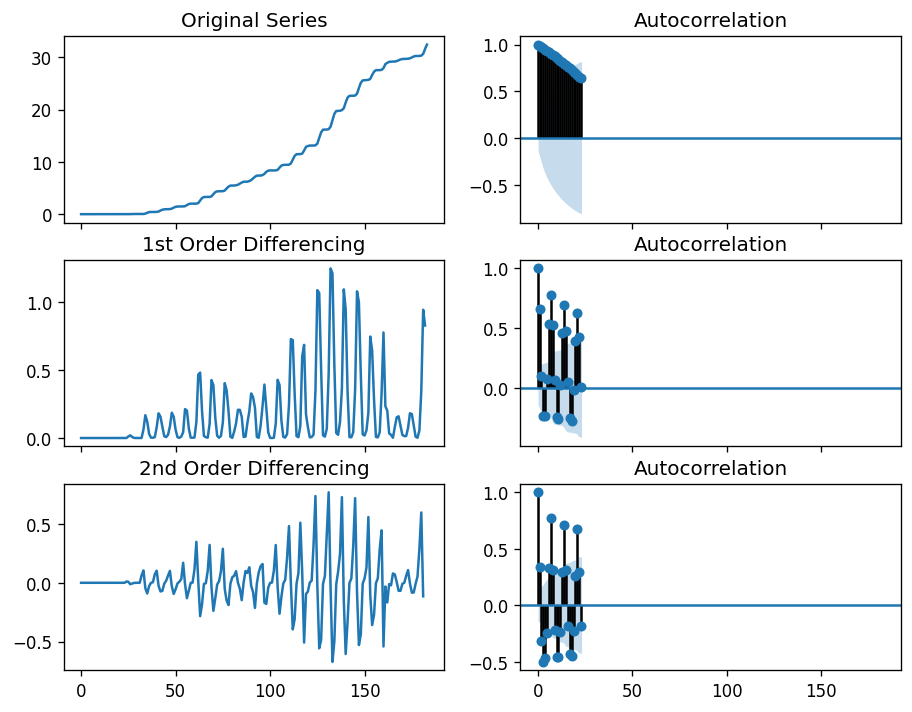

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-77.500, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-31.698, Time=0.20 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-52.204, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-78.430, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-33.620, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-115.431, Time=0.36 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-116.135, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-80.409, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-131.565, Time=0.25 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-79.474, Time=0.08 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-202.385, Time=0.30 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-178.052, Tim

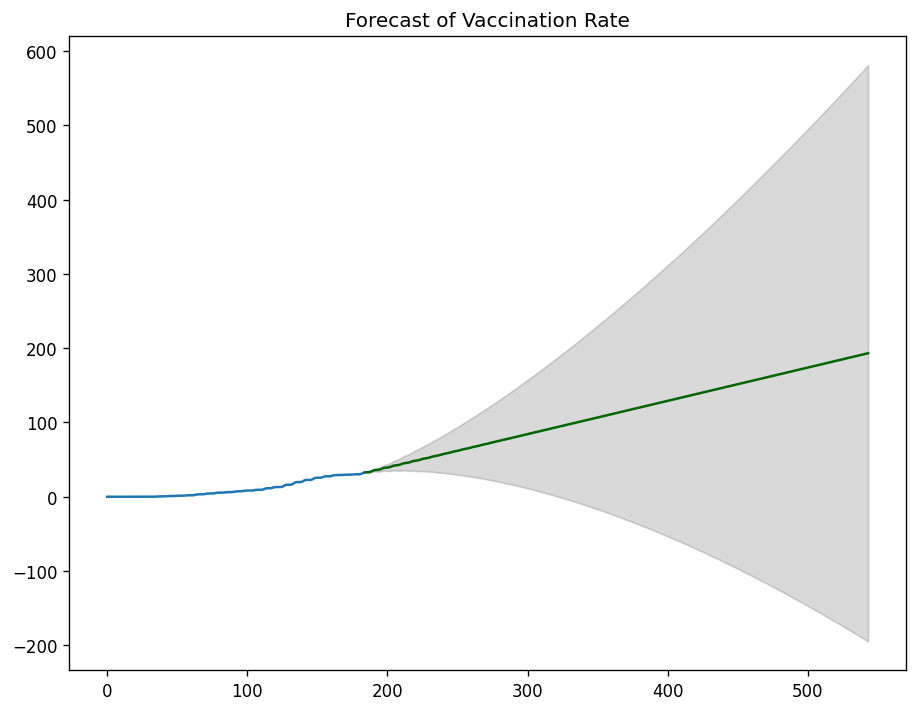

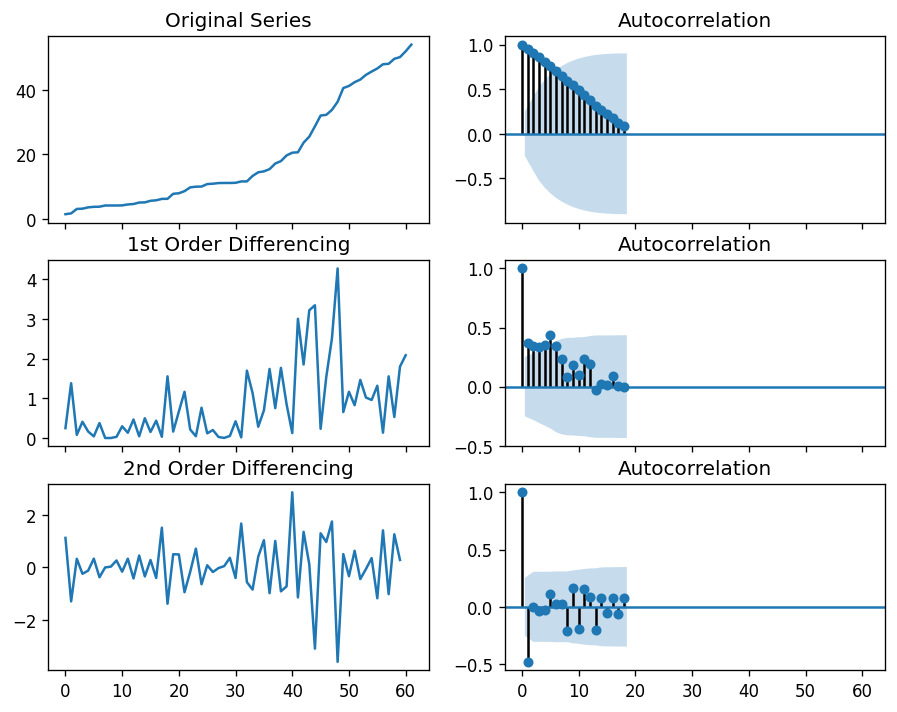

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=155.753, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=180.840, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=166.996, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=153.762, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=178.890, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=155.752, Time=0.16 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=157.637, Time=0.19 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=152.319, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=154.261, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=154.248, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=165.078, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=155.880, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.952 seconds
                               SARIMAX Results                                
Dep. Variable:       

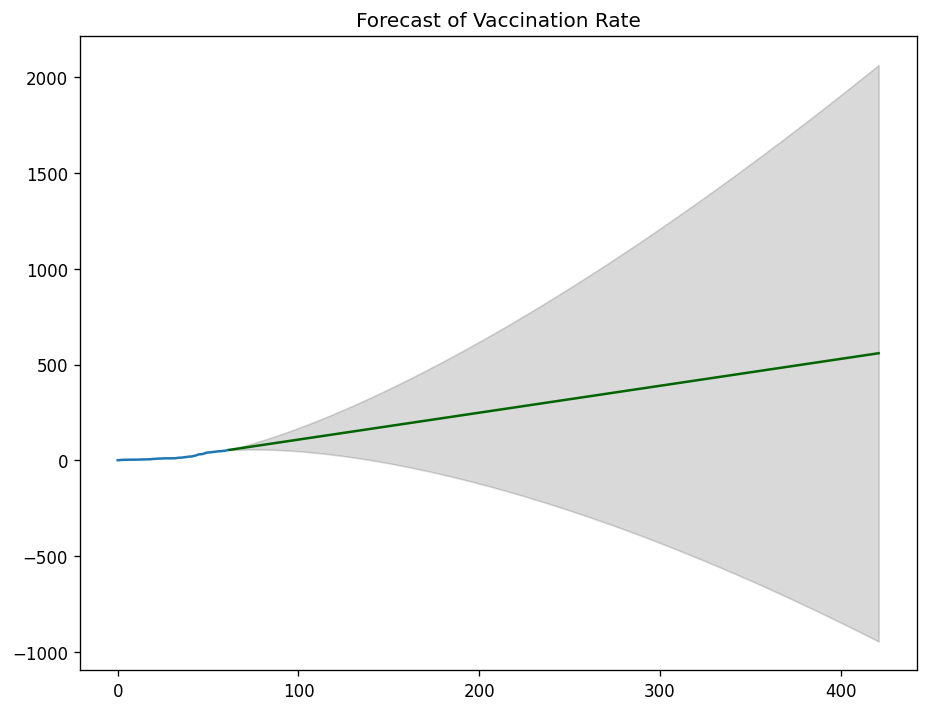

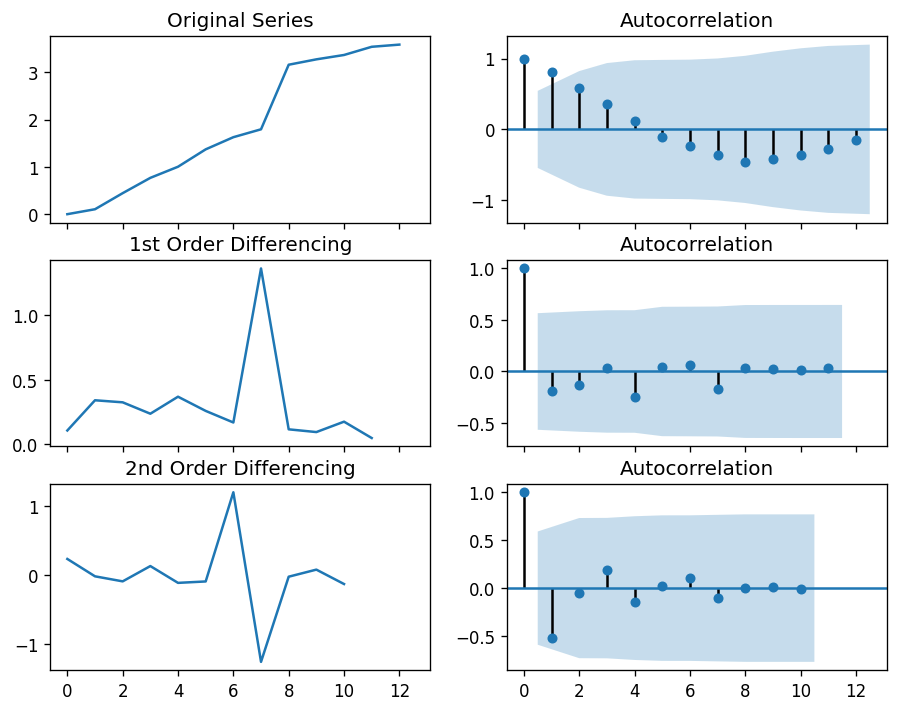

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=21.369, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=20.165, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=19.370, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.428 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   13
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  -8.685
Date:                Fri, 04 Jun 2021   AIC                             19.370
Time:                        21:05:02   BIC                             19.768
Sample:                             0   HQIC                            19.119
                                 - 13                                         
Covariance Ty

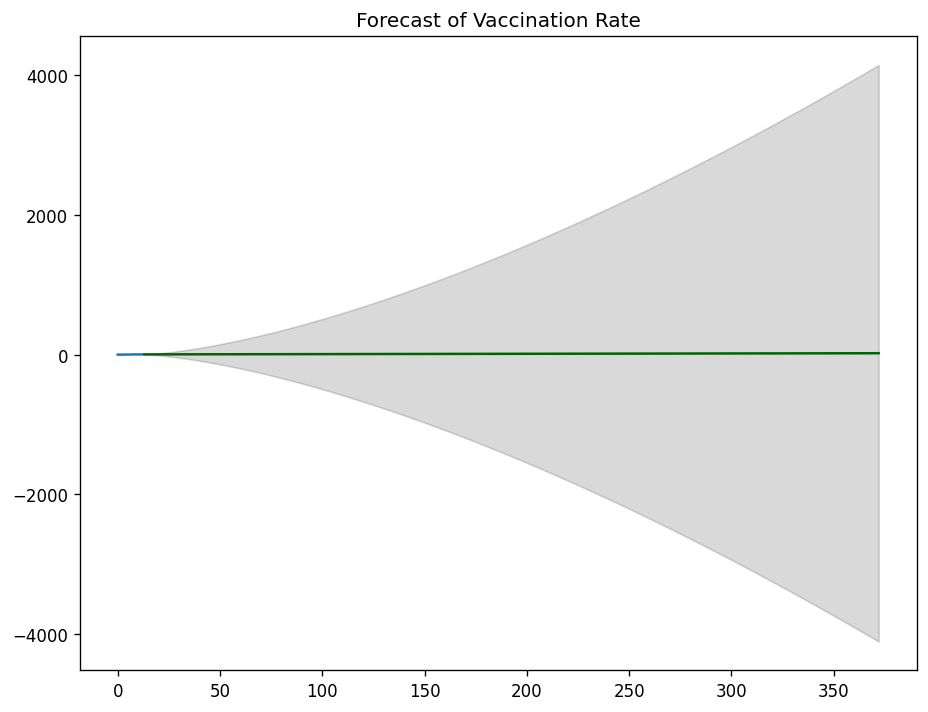

In [ ]:
import math
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
country_list = ['PYF', 'AUS', 'EGY', 'USA', 'BRA', 'DEU', 'DNK', 'ZAF', 'RUS', 'GTM',
                'NGA', 'ESP', 'IRN', 'ETH', 'IDN', 'GBR', 'MEX', 'COL', 'CHE', 'LKA', 'TUR', 'NAM',
                'JOR', 'ARG', 'NOR', 'ISL', 'UZB', 'CAN']


#create one big dataframe within the for loop
big_data= pd.DataFrame()       
                       
for country in country_list:
  df = df.sort_values('location')
  df['eid'] = (df.groupby(['location']).cumcount()==0).astype(int)
  df['eid'] = df['eid'].cumsum()
  ndf=df[df.iso_code==country]

  #check dataframe of country
  sndf = ndf.sort_values('people_vaccinated')
  val = sndf['people_vaccinated'].values * 100 /list(ndf.population)[0]

  for i in range(len(val)):
    if val[i]>=0:
      pass
    else :
      end = i
      break

  val = val[:end]
  d = list(sndf.date)[:end]
  fig, axes = plt.subplots(3, 2, sharex=True)
  axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
  plot_acf(val, ax=axes[0, 1])

  # 1st Differencing
  axes[1, 0].plot(np.diff(val)); axes[1, 0].set_title('1st Order Differencing')
  plot_acf(np.diff(val), ax=axes[1, 1])
  diffval = np.diff(val)

  # 2nd Differencing
  axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
  plot_acf(np.diff(diffval), ax=axes[2, 1])
  plt.show()

  #arima model parameters
  model = pm.auto_arima(val, start_p=1, start_q=1,
  test='adf', # use adftest to find optimal 'd'
  max_p=4, max_q=4, # maximum p and q
  m=1, # frequency of series
  d=None, # let model determine 'd'
  seasonal=False, # No Seasonality
  start_P=0,
  D=0,
  trace=True,
  error_action='ignore',
  suppress_warnings=True,
  stepwise=True)
  print(model.summary())
  # model.plot_diagnostics(figsize=(7,5))
  plt.show()
  n_periods = 12*30
  fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
  index_of_fc = np.arange(len(val), len(val)+n_periods)

  # make series for plotting purpose
  fc_series = pd.Series(fc, index=index_of_fc)
  lower_series = pd.Series(confint[:, 0], index=index_of_fc)
  upper_series = pd.Series(confint[:, 1], index=index_of_fc)
  # Plot
  plt.plot(val)
  plt.plot(fc_series, color='darkgreen')
  plt.fill_between(lower_series.index,
  lower_series,
  upper_series,
  color='k', alpha=.15)
  plt.title("Forecast of Vaccination Rate")
  plt.show()

  for i in range(n_periods):
    date = parse(d[-1]) + datetime.timedelta(days=1)
    d.append(str(date).split()[0])

  #calculates the lag
  vaccinated = (sndf.dropna(subset=["people_vaccinated"])["people_vaccinated"]*100/list(ndf.population)[0]).tolist()
  fully_vaccinated = (sndf.dropna(subset=["people_vaccinated"])["people_fully_vaccinated"]*100/list(ndf.population)[0]).tolist()
  mseMin = math.inf
  lagMin=0

  for lag in range(0,139):
    vacNew = vaccinated[:len(vaccinated)-lag]
    fullVacNew = fully_vaccinated[lag:]
    mse = 0
    if len(fullVacNew)> 0:
      for i in range(len(fullVacNew)):
        mse += (vacNew[i] - fullVacNew[i])**2
        mse = mse/len(vacNew)
      if mse < mseMin:
        lagMin = lag
        mseMin = mse
    else:
      pass
 
  y = list(val) + list(fc)

  dfp = pd.DataFrame()
  dfp['date'] = d
  dfp["date"] = pd.to_datetime(dfp["date"]) #convert string into datetime object
  dfp["date_adjusted"] =  dfp["date"] + datetime.timedelta(days=lagMin) #add lag factor
  dfp['people_fully_vaccinated'] = y
  dfp['location']= country
  big_data= pd.concat([big_data, dfp], axis=0, sort=False, ignore_index=True)

big_data.to_csv(f'world_data_forecast.csv', index= False)

In [ ]:
plt.plot(range(len(vaccinated)),vaccinated)
plt.plot(range(len(vaccinated)),fully_vaccinated)

In [ ]:
plt.plot(range(len(vacNew)),vacNew)
plt.plot(range(len(fullVacNew)),fullVacNew)